## Read the data from RDS file

In [1]:
library(WGCNA)
library(reshape2)
library(stringr)
library(dplyr)
library(ggplot2)
library(tidyr)
# 
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()

## Allowing parallel execution with maximum threads


# Deseq2的varianceStabilizingTransformation

# exprMat <- './csv/reduced_assay_vst_shoot_3DMs_Mine_20220421.csv'

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




Allowing parallel execution with up to 127 working processes.


In [2]:
dataExpr <- readRDS('./Rdata/vst.Rds') %>% as.data.frame 
# dataExpr

In [3]:
map_id_name <- read.csv('../gene_table_and_other_scripts/bioMartR_Ath_all_genes_info_googled.csv')
map_id_name <- map_id_name %>% dplyr::rename('gene_name' = 'external_gene_name', 'gene_id' = 'ensembl_gene_id')
sample_n(map_id_name, 2)

gene_id   gene_name
1 AT4G14860 OFP11    
2 ATCG00420 ndhJ

In [4]:
map_id_name %>% filter(gene_name %>% str_detect('^\\d'))

gene_id   gene_name              
1  AT5G38120 4CL8                   
2  AT5G13050 5-FCL                  
3  AT3G21240 4CL2                   
4  AT2G26260 3BETAHSD/D2            
5  AT1G51680 4CL1                   
6  AT4G23800 3xHMG-box2             
7  AT1G65060 4CL3                   
8  AT1G47510 5PTASE11               
9  AT1G03410 2A6                    
10 AT2G43900 5PTase12               
11 AT5G06290 2-Cys Prx B            
12 AT3G21230 4CL5                   
13 AT4G11080 3xHMG-box1             
14 AT1G47290 3BETAHSD/D1            
15 AT2G31830 5PTase14               
16 AT1G05630 5PTASE13               
17 AT3G09570 7TM2                   
18 AT5G42090 7TM4                   
19 AT3G19480 3-PGDH                 
20 AT2G01070 7TM5                   
21 AT3G19010 2-OXOGLUTARATEOXYGENASE
22 AT3G11630 2CPA

In [5]:
source('../gene_table_and_other_scripts/theme_Publication.R')

Registering fonts with R

aakar already registered with pdfFont().

Abyssinica SIL already registered with pdfFont().

Andale Mono already registered with pdfFont().

Ani already registered with pdfFont().

AnjaliOldLipi already registered with pdfFont().

Arial already registered with pdfFont().

Arial Black already registered with pdfFont().

Chandas already registered with pdfFont().

Comic Sans MS already registered with pdfFont().

Courier New already registered with pdfFont().

DejaVu Sans already registered with pdfFont().

DejaVu Sans Mono already registered with pdfFont().

DejaVu Serif already registered with pdfFont().

Dhurjati already registered with pdfFont().

Droid Sans Fallback already registered with pdfFont().

Dyuthi already registered with pdfFont().

FreeMono already registered with pdfFont().

FreeSans already registered with pdfFont().

FreeSerif already registered with pdfFont().

Gargi already registered with pdfFont().

Garuda already registered with pdfFont(

In [6]:
Ath_TFs <- read.csv('../3DMs_pathogen/TFs/Ath_TF_list.txt', sep = '\t')

In [7]:
WGCNA_export_path <- './WGCNA_output_all'

create_directory_if_not_exists <- function(dir_path) {
  # Check if the directory exists; if not, create the directory
  if (!file.exists(dir_path)) {
    dir.create(dir_path, recursive = TRUE)
  }
}

create_directory_if_not_exists(WGCNA_export_path)

plots_path <- paste0(WGCNA_export_path, "/plots/")
create_directory_if_not_exists(plots_path)

In [8]:

type = "signed"

# cor
#  biweight mid-correlation & bicor
# corType: pearson or bicor

corType = "bicor"

corFnc = ifelse(corType=="pearson", cor, bicor)

maxPOutliers = ifelse(corType=="pearson",1,0.05)


robustY = ifelse(corType=="pearson",T,F)

In [9]:
head(dataExpr, 2)
dim(dataExpr)

DM1/DM2d_1 Col-0_12_1 DM1/DM2d_2 Col-0_12_2 DM1/DM2d_3 DM6/DM7_1
AT1G30814 7.854118   7.134483   8.072488   6.900123   7.904952   7.665448 
AT1G78930 8.322251   9.048173   7.991578   9.229448   8.210870   8.598738 
          Col-0_14_1 DM6/DM7_2 Col-0_14_2 DM6/DM7_3 ⋯ S12-C    M20-A   
AT1G30814 6.900123   7.926750  6.900123   7.668472  ⋯ 7.743128 6.900123
AT1G78930 8.638332   8.435372  8.537098   8.585173  ⋯ 9.917472 9.263148
          M20-B    M20-C    R20-A    R20-B    R20-C    S20-A    S20-B   
AT1G30814 6.900123 6.900123 8.713060 8.689767 8.708205 8.756711 8.550218
AT1G78930 9.600597 9.649772 9.020265 8.666605 8.992366 8.878447 9.007046
          S20-C   
AT1G30814 8.408096
AT1G78930 8.962624

[1] 27270    71

In [10]:
sample_names <- data.frame(name = rownames(dataExpr)  )

In [11]:
sample_names %>% mutate(name2 = name %>% str_remove('_[\\dA-Za-z]$') %>% str_remove('-[\\dA-Za-z]$')) %>%
    group_by(name2) %>% summarise(n = n())
    

name2     n
1     AT1G01010 1
2     AT1G01020 1
3     AT1G01030 1
4     AT1G01040 1
5     AT1G01046 1
6     AT1G01050 1
7     AT1G01060 1
8     AT1G01070 1
9     AT1G01080 1
10    AT1G01090 1
11    AT1G01100 1
12    AT1G01110 1
13    AT1G01120 1
14    AT1G01130 1
15    AT1G01140 1
16    AT1G01150 1
17    AT1G01160 1
18    AT1G01170 1
19    AT1G01180 1
20    AT1G01183 1
21    AT1G01190 1
22    AT1G01200 1
23    AT1G01210 1
24    AT1G01220 1
25    AT1G01225 1
26    AT1G01230 1
27    AT1G01240 1
28    AT1G01250 1
29    AT1G01260 1
30    AT1G01280 1
⋮     ⋮         ⋮
27241 ATMG01190 1
27242 ATMG01200 1
27243 ATMG01210 1
27244 ATMG01220 1
27245 ATMG01230 1
27246 ATMG01240 1
27247 ATMG01250 1
27248 ATMG01260 1
27249 ATMG01270 1
27250 ATMG01275 1
27251 ATMG01280 1
27252 ATMG01290 1
27253 ATMG01300 1
27254 ATMG01310 1
27255 ATMG01320 1
27256 ATMG01330 1
27257 ATMG01340 1
27258 ATMG01350 1
27259 ATMG01360 1
27260 ATMG01370 1
27261 ATMG01380 1
27262 ATMG01390 1
27263 ATMG01400 1
27264 ATMG01410 1
27265 ATMG09450 1
27266 ATMG09730 1
27267 ATMG09740 1
27268 ATMG09950 1
27269 ATMG09960 1
27270 ATMG09980 1

### remove DM10/DM11 samples

In [12]:
# dataExpr <- dataExpr %>% dplyr::select(!matches('Tuescha|Cdm|DM11'))

## Check samples: all samples look evenly

In [13]:
options(repr.plot.width=12, repr.plot.height=8)
pdf(file = paste0(plots_path, "sapmle_barplot_", Sys.time(), '.pdf'),  wi = 12, he = 8)
boxplot(dataExpr) 
dev.off()

png 
  2

## choose top 20% most variable genes accross all samples

In [14]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.8))[2],0.01)),]

## transpose, the genes are column
dataExpr <- as.data.frame(t(dataExprVar))


gsg = goodSamplesGenes(dataExpr, verbose = 3)

##  Flagging genes and samples with too many missing values...
##   ..step 1
gsg$allOK
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}

nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)

dim(dataExpr)

## [1]  134 2697

head(dataExpr)[,1:8]

##       MMT00000051 MMT00000080 MMT00000102 MMT00000149 MMT00000159
## F2_2  -0.02260000 -0.04870000  0.17600000  0.07680000 -0.14800000
## F2_3   0.06170000  0.05820000 -0.18900000  0.18600000  0.17700000

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

[1]   71 5454

AT1G69810 AT1G52200 AT1G71890 AT1G80870 AT1G47900 AT1G19715
DM1/DM2d_1 9.265026  14.09817  8.237040   8.575142  9.509747  8.859563
Col-0_12_1 8.131310  11.82631  8.037637   9.112330 11.301110 10.732077
DM1/DM2d_2 9.240087  14.07083  8.193998   8.586995  9.567334  8.988276
Col-0_12_2 8.231868  11.55445  8.287390   9.239839 11.237102 10.679388
DM1/DM2d_3 9.126552  13.90354  8.347767   8.610593  9.665241  8.880352
DM6/DM7_1  9.278535  12.28272  8.805269  10.139657  9.532483 11.130371
           AT1G53625 AT1G51440
DM1/DM2d_1 10.642340 6.900123 
Col-0_12_1  7.288023 8.839410 
DM1/DM2d_2 10.594132 7.112101 
Col-0_12_2  7.070480 8.382313 
DM1/DM2d_3 10.448508 7.048042 
DM6/DM7_1   9.727366 7.366667

In [15]:
gene.names <- colnames(dataExpr)
head(gene.names)

[1] "AT1G69810" "AT1G52200" "AT1G71890" "AT1G80870" "AT1G47900" "AT1G19715"

### Sample Clustering

png 
  2

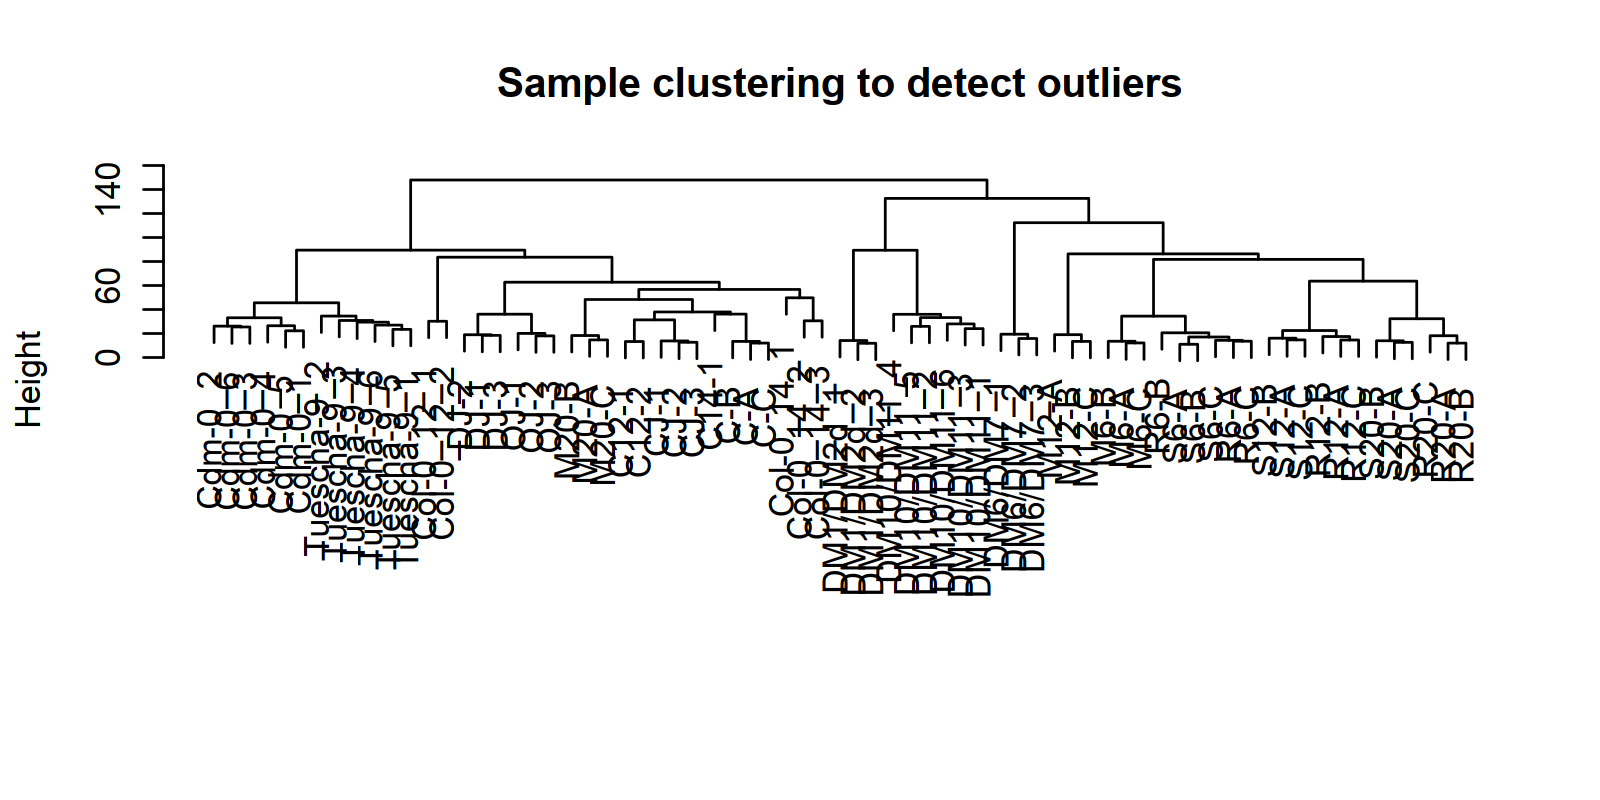

In [16]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 200)
## 查看是否有离群样品
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

pdf(file = paste0(plots_path, 'sample_clustering',Sys.time(), '.pdf'), width = 9.5, height = 4)
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="", cex= 0.7)
dev.off()

## Determine Soft threshold (power)

http://pklab.med.harvard.edu/scw2014/WGCNA.html

pickSoftThreshold: will use block size 5454.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 5454 of 5454
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.28500  9.8800        0.96800    2770    2780.0   3030
2      2  0.85400  5.2000        0.83400    1900    1960.0   2210
3      3  0.91300  2.2300        0.89000    1470    1560.0   1880
4      4  0.87800  1.3300        0.85500    1190    1300.0   1660
5      5  0.72100  0.8310        0.64800    1000    1100.0   1510
6      6  0.48700  0.5080        0.34000     858     948.0   1390
7      7  0.22000  0.2870        0.00636     745     823.0   1290
8      8  0.04070  0.1150       -0.20300     654     720.0   1200
9      9  0.00407 -0.0391       -0.21100     579     634.0   1120
10    10  0.04900 -0.1420       -0.11500     516     561.0   1050
11    12  0.17900 -0.3170        0.11900     417     445.0    925
12    14  0.28700 -0.4320        0.30500     343     

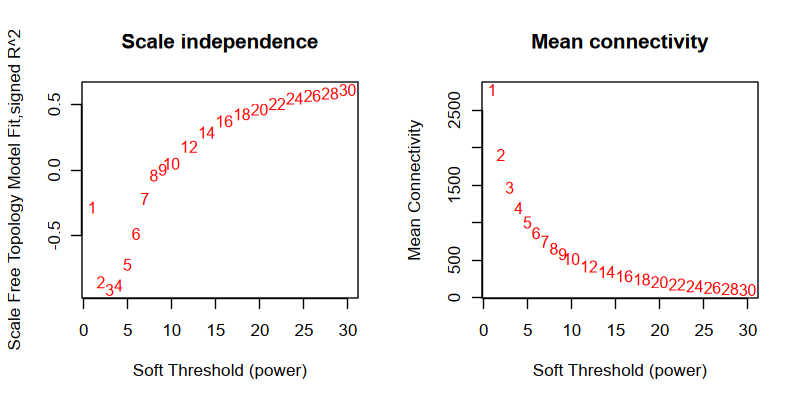

In [17]:
options(repr.plot.width=8, repr.plot.height=4, repr.plot.res = 100)

powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.85,col="red")

# Soft threshold与平均连通性
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [18]:
power = sft$powerEstimate
power

[1] 2

### construct network, decide power

In [19]:
### 无向网络在power小于15或有向网络power小于30内，没有一个power值可以使
### 无标度网络图谱结构R^2达到0.8，平均连接度较高如在100以上，可能是由于
### 部分样品与其他样品差别太大。这可能由批次效应、样品异质性或实验条件对
### 表达影响太大等造成。可以通过绘制样品聚类查看分组信息和有无异常样品。
### 如果这确实是由有意义的生物变化引起的，也可以使用下面的经验power值。
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}
power

[1] 2

In [20]:
print(paste('calculating power = ' , power) )

[1] "calculating power =  2"


### Generating adjacency and TOM similarity matrices based on the selected softpower

#### manually assign power if softpowder doesn't work

In [21]:
softPower = 14;

#calclute the adjacency matrix
adj= adjacency(dataExpr,type = type, power = softPower);

#turn adjacency matrix into topological overlap to minimize the effects of noise and spurious associations
TOM=TOMsimilarityFromExpr(dataExpr,networkType = type, TOMType = type, power = softPower);

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [22]:
colnames(TOM) =rownames(TOM) = gene.names
dissTOM=1-TOM

In [23]:
library(flashClust)


Attaching package: ‘flashClust’


The following object is masked from ‘package:fastcluster’:

    hclust


The following object is masked from ‘package:stats’:

    hclust




In [24]:
geneTree = flashClust(as.dist(dissTOM),method="average")

In [25]:
options(repr.plot.width=14, repr.plot.height=10, repr.plot.res = 140)
# Set the minimum module size
minModuleSize = 30

# Module identification using dynamic tree cut

#dynamicMods = cutreeDynamic(dendro = geneTree,  method="hybrid", distM = dissTOM, 
#                            minClusterSize = minModuleSize);
dynamicMods = cutreeDynamic(dendro = geneTree, distM = dissTOM, method="hybrid", deepSplit = 2, pamRespectsDendro = FALSE, minClusterSize = minModuleSize);

#default deepSplit = 2

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)


dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

# plotDendroAndColors(geneTree, dynamicColors, "Dynamic Tree Cut", dendroLabels = FALSE, hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")

 ..cutHeight not given, setting it to 0.992  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamicMods
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1202  727  581  546  381  300  293  293  285  125   93   84   63   60   58   55 
  17   18   19   20   21   22   23 
  55   54   50   44   38   34   33 

dynamicColors
        black          blue         brown          cyan     darkgreen 
          293           727           581            60            34 
      darkred darkturquoise         green   greenyellow        grey60 
           38            33           381            93            55 
    lightcyan    lightgreen   lightyellow       magenta  midnightblue 
           55            54            50           285            58 
         pink        purple           red     royalblue        salmon 
          293           125           300            44            63 
          tan     turquoise        yellow 
           84          1202           546 

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


dynamicMods
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
1202  727  581  546  381  300  293  293  285  125   93   84   63   60   58   55 
  17   18   19   20   21   22   23 
  55   54   50   44   38   34   33 

dynamicColors
        black          blue         brown          cyan     darkgreen 
          293           727           581            60            34 
      darkred darkturquoise         green   greenyellow        grey60 
           38            33           381            93            55 
    lightcyan    lightgreen   lightyellow       magenta  midnightblue 
           55            54            50           285            58 
         pink        purple           red     royalblue        salmon 
          293           125           300            44            63 
          tan     turquoise        yellow 
           84          1202           546 

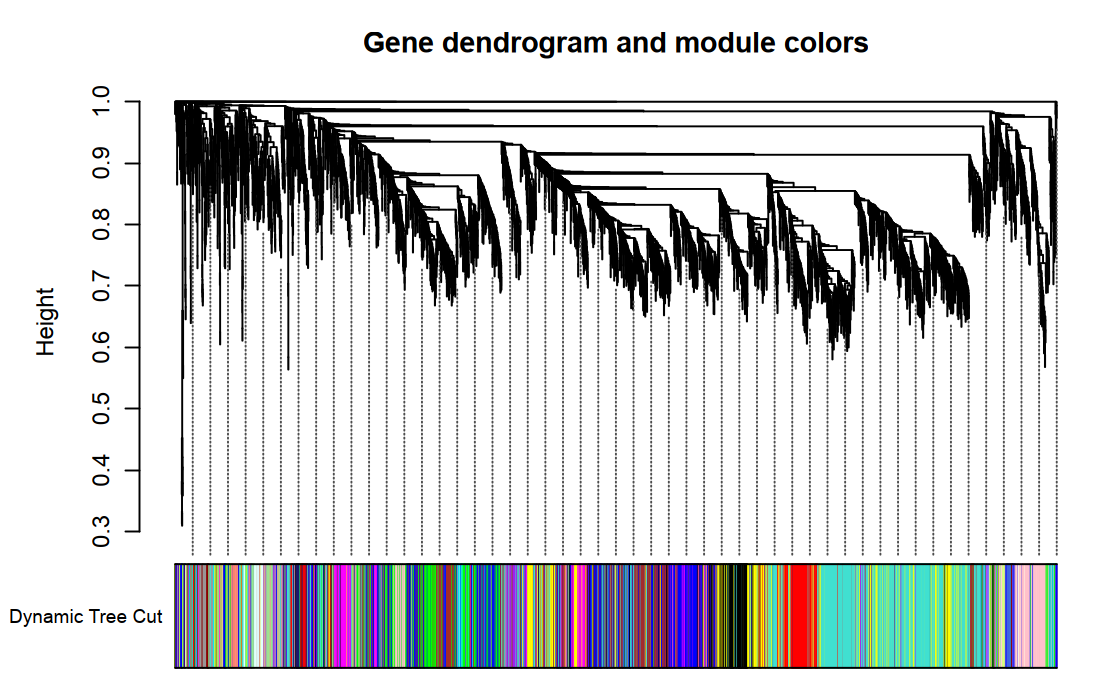

In [26]:
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 140)

#discard the unassigned genes, and focus on the rest
restGenes= (dynamicColors != "grey")
diss1=1-TOMsimilarityFromExpr(dataExpr[,restGenes], power = softPower)

#the following command gives the module labels and the size of each module. Lable 0 is reserved for unassigned genes
table(dynamicMods)

#Plot the module assignment under the dendrogram; note: The grey color is reserved for unassigned genes
dynamicColors = labels2colors(dynamicMods)
table(dynamicColors)

colnames(diss1) =rownames(diss1) = gene.names[restGenes]
hier1=flashClust(as.dist(diss1), method="average" )
plotDendroAndColors(hier1, dynamicColors[restGenes], "Dynamic Tree Cut", dendroLabels = FALSE, 
                    hang = 0.03, addGuide = TRUE, guideHang = 0.05, main = "Gene dendrogram and module colors")

## merged mod

https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/Tutorials/FemaleLiver-02-networkConstr-man.pdf

In [27]:
# Calculate eigengenes
MEList = moduleEigengenes(dataExpr, colors = dynamicColors)
MEs = MEList$eigengenes
# Calculate dissimilarity of module eigengenes
MEDiss = 1-cor(MEs);
# Cluster module eigengenes
METree = hclust(as.dist(MEDiss), method = "average");
# Plot the result
sizeGrWindow(7, 6)
plot(METree, main = "Clustering of module eigengenes",
xlab = "", sub = "")

MEDissThres = 0.25 #0.25 default
# Plot the cut line into the dendrogram
abline(h=MEDissThres, col = "red")
# Call an automatic merging function
merge = mergeCloseModules(dataExpr, dynamicColors, cutHeight = MEDissThres, verbose = 3)
# The merged module colors
mergedColors = merge$colors;
# Eigengenes of the new merged modules:
mergedMEs = merge$newMEs;


 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 23 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 10 module eigengenes in given set.


In [28]:
table(mergedColors)

mergedColors
         blue          cyan     darkgreen       darkred darkturquoise 
         2222          2490            84            93            33 
  greenyellow  midnightblue        purple        salmon           tan 
           93            58           234            63            84 

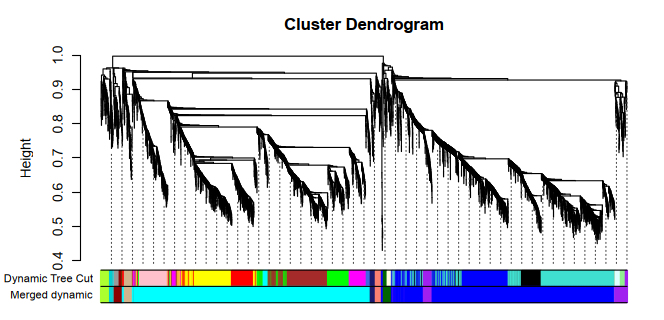

In [29]:

options(repr.plot.width=8.3, repr.plot.height=4, repr.plot.res = 80)

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
                     autoColorHeight = FALSE,    colorHeight = 0.16,
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)

In [30]:
#sizeGrWindow(12, 9)
pdf(file = paste0(plots_path, 'plotDendroAndColors' ,Sys.time(), '.pdf'),  wi = 3.5, he = 5)

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
c("Dynamic Tree Cut", "Merged dynamic"),
autoColorHeight = FALSE,    colorHeight = 0.16,
dendroLabels = FALSE, hang = 0.03,
addGuide = TRUE, guideHang = 0.05)
dev.off()

png 
  2

In [31]:
library(extrafont)

# Set global font size and family
par(cex=0.8, family="Arial")

# Save the plot
pdf(file = paste0(plots_path, 'plotDendroAndColors' ,Sys.time(), '.pdf'),  wi = 3.3, he = 5, family = "Arial")

plotDendroAndColors(geneTree, cbind(dynamicColors, mergedColors),
                    c("Dynamic Tree Cut", "Merged dynamic"),
                    autoColorHeight = FALSE,    
                    colorHeight = 0.16,
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

dev.off()


png 
  2

In [32]:
hubs = chooseTopHubInEachModule(dataExpr, colorh=  mergedColors, power=power, type=type)
hubs

blue          cyan     darkgreen       darkred darkturquoise 
  "AT1G75680"   "AT5G42010"   "AT3G15940"   "AT2G39330"   "AT5G14580" 
  greenyellow  midnightblue        purple        salmon           tan 
  "AT5G27890"   "AT3G11010"   "AT4G27030"   "AT3G44670"   "AT5G24470"

## export module hub genes from, sorted by connectivity

In [33]:
# the grey module is omitted
topHubs <- function (datExpr, colorh, omitColors = "grey", power = 2, type = "signed", 
    ...) 
{
    # modified from chooseTopHubInEachModule, but return the table of all genes connectivity
    isIndex = FALSE
    modules = names(table(colorh))
    if (!is.na(omitColors)[1]) 
        modules = modules[!is.element(modules, omitColors)]
    if (is.null(colnames(datExpr))) {
        colnames(datExpr) = 1:dim(datExpr)[2]
        isIndex = TRUE
    }
    
    connectivity_table <- data.frame(matrix(ncol = 3)) %>% setNames(c('gene', 'connectivity_rowSums_adj', 'module'))
    hubs = rep(NA, length(modules))
    names(hubs) = modules
    for (m in modules) {
        adj = adjacency(datExpr[, colorh == m], power = power, 
            type = type, ...)

        hub = which.max(rowSums(adj))

        hubs[m] = colnames(adj)[hub]

        sorted_genes <- rowSums(adj) %>% sort(decreasing = T) %>% as.data.frame()  %>%  
                tibble::rownames_to_column() %>% setNames(c('gene', 'connectivity_rowSums_adj')) %>% mutate(module = m)
        connectivity_table <- connectivity_table %>% rbind(sorted_genes)



    }
    if (isIndex) {
        hubs = as.numeric(hubs)
        names(hubs) = modules
    }
    return(connectivity_table %>% na.omit)
}

In [34]:
connectivity_table= topHubs(dataExpr, colorh=  mergedColors, power=power, type=type)

In [35]:
connectivity_table <- connectivity_table %>% left_join(map_id_name, by =c('gene' = 'gene_id'))

In [36]:
connectivity_table %>% group_by(module) %>% top_n(2, wt = connectivity_rowSums_adj)

gene      connectivity_rowSums_adj module        gene_name        
1  AT1G75680 1824.90372               blue          GH9B7            
2  AT1G55360 1819.23727               blue          -1803            
3  AT5G42010 1955.10496               cyan          AT5G42010        
4  AT1G63720 1954.52831               cyan          AT1G63720        
5  AT3G15940   66.55779               darkgreen     Gene.ID#AT3G15940
6  AT3G19400   66.55244               darkgreen     AT3G19400        
7  AT2G39330   76.82642               darkred       JAL23            
8  AT3G16470   76.78207               darkred       JR1              
9  AT5G14580   27.63659               darkturquoise AT5G14580        
10 AT3G12270   27.14098               darkturquoise PRMT3            
11 AT5G27890   72.78292               greenyellow   AT5G27890        
12 AT1G58807   71.54586               greenyellow   AT1G58807        
13 AT3G11010   46.68285               midnightblue  RLP34            
14 AT5G10760   46.17556               midnightblue  AED1             
15 AT4G27030  188.21548               purple        FADA             
16 AT2G26080  187.97010               purple        GLDP2            
17 AT3G44670   50.10345               salmon        DM2H             
18 AT3G28100   49.71324               salmon        UMAMIT45         
19 AT5G24470   68.75528               tan           PRR5             
20 AT1G68050   67.89177               tan           FKF1

In [37]:
top_50_each_module <- connectivity_table %>% group_by(module) %>% top_n(50, wt = connectivity_rowSums_adj)

In [38]:
require(openxlsx)

wb <- createWorkbook()
for (i in connectivity_table %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, connectivity_table %>% filter(module == i))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "connectivity_each_gene_in_module.xlsx"), overwrite = T)

Loading required package: openxlsx



In [39]:
connectivity_table

gene      connectivity_rowSums_adj module gene_name
1    AT1G75680 1824.904                 blue   GH9B7    
2    AT1G55360 1819.237                 blue   -1803    
3    AT1G12090 1816.806                 blue   ELP      
4    AT1G60800 1816.019                 blue   NIK3     
5    AT2G28150 1815.735                 blue   SOK3     
6    AT3G59420 1812.118                 blue   CR4      
7    AT2G41820 1809.740                 blue   PXC3     
8    AT3G61550 1809.641                 blue   ATL68    
9    AT5G49100 1809.288                 blue   AT5G49100
10   AT1G18650 1809.029                 blue   PDCB3    
11   AT1G13250 1808.803                 blue   GATL3    
12   AT2G10940 1808.031                 blue   AT2G10940
13   AT3G06770 1807.759                 blue   PGF4     
14   AT2G27040 1804.954                 blue   AGO4     
15   AT2G45470 1804.179                 blue   FLA8     
16   AT3G16370 1803.612                 blue   GGL19    
17   AT3G17640 1802.301                 blue   AT3G17640
18   AT3G63200 1802.084                 blue   PLP9     
19   AT4G27430 1801.627                 blue   CIP7     
20   AT3G56160 1801.101                 blue   AT3G56160
21   AT1G54820 1801.096                 blue   AT1G54820
22   AT3G49670 1801.059                 blue   BAM2     
23   AT1G69420 1800.891                 blue   AT1G69420
24   AT5G18660 1800.268                 blue   PCB2     
25   AT5G16590 1800.203                 blue   LRR1     
26   AT2G05790 1799.508                 blue   AT2G05790
27   AT3G29030 1799.387                 blue   EXPA5    
28   AT3G59780 1798.710                 blue   AT3G59780
29   AT4G28780 1798.249                 blue   AT4G28780
30   AT2G40490 1798.083                 blue   HEME2    
⋮    ⋮         ⋮                        ⋮      ⋮        
5425 AT3G10410 58.48944                 tan    SCPL49   
5426 AT2G19450 58.45477                 tan    TAG1     
5427 AT3G15840 58.19861                 tan    PIFI     
5428 AT1G21680 58.10934                 tan    AT1G21680
5429 AT2G15880 57.85079                 tan    LRX10    
5430 AT5G03720 57.69623                 tan    HSFA3    
5431 AT3G26580 57.25936                 tan    AT3G26580
5432 AT5G51570 56.55389                 tan    HIR3     
5433 AT2G21060 56.45139                 tan    GRP2B    
5434 AT1G11210 56.16990                 tan    AT1G11210
5435 AT3G05880 56.00421                 tan    RCI2A    
5436 AT2G21130 55.71314                 tan    AT2G21130
5437 AT1G74680 55.41274                 tan    AT1G74680
5438 AT5G50450 54.79489                 tan    AT5G50450
5439 AT3G05220 53.84413                 tan    ATHMP23  
5440 AT3G54366 53.60991                 tan    AT3G54366
5441 AT4G29190 53.13182                 tan    OZF2     
5442 AT2G36420 52.73327                 tan    TRM27    
5443 AT1G51090 52.58000                 tan    ATHMAD1  
5444 AT1G33970 52.49333                 tan    IAN9     
5445 AT1G20920 52.22843                 tan    RCF1     
5446 AT1G26580 52.12148                 tan    AT1G26580
5447 AT1G15870 51.36827                 tan    AT1G15870
5448 AT3G20810 51.26027                 tan    JMJD5    
5449 AT4G31290 49.74251                 tan    GGCT2;2  
5450 AT5G43440 49.65174                 tan    AT5G43440
5451 AT4G39260 49.00846                 tan    CCR1     
5452 AT4G16857 48.47073                 tan    AT4G16857
5453 AT3G10020 47.62091                 tan    HUP26    
5454 AT2G02160 47.11706                 tan    ATC3H17

In [40]:
# Rename to moduleColors
moduleColors = mergedColors
# Construct numerical labels corresponding to the colors
colorOrder = c("grey", standardColors(50));
moduleLabels = match(moduleColors, colorOrder)-1;
MEs = mergedMEs;
# Save module colors and labels for use in subsequent parts
#save(MEs, moduleLabels, moduleColors, geneTree, file = "FemaleLiver-02-networkConstruction-stepByStep.RData")

In [41]:
moduleColors %>% unique()
MEs %>% head(2)

[1] "cyan"          "purple"        "blue"          "darkred"      
 [5] "midnightblue"  "salmon"        "darkturquoise" "greenyellow"  
 [9] "darkgreen"     "tan"

MEblue      MEpurple   MEdarkturquoise MEcyan      MEdarkred  
DM1/DM2d_1 -0.20568039 -0.1557923 -0.2208651       0.16508252 -0.15081550
Col-0_12_1  0.07341693 -0.0319329 -0.0755548      -0.06875897 -0.01812837
           MEgreenyellow MEsalmon     MEtan      MEdarkgreen MEmidnightblue
DM1/DM2d_1 -0.06307087    0.197631192 0.02351471 0.15351248  0.200398583   
Col-0_12_1  0.02593431   -0.005166699 0.07076801 0.01114131  0.006875687

In [42]:
#set the diagonal of the dissimilarity to NA 
diag(diss1) = NA;

#Visualize the Tom plot. Raise the dissimilarity matrix to the power of 4 to bring out the module structure
#sizeGrWindow(7,7)

pdf(file = paste0(plots_path, 'TOMplot' ,Sys.time(), '.pdf'),  wi = 6, he = 12)
TOMplot(diss1, hier1, as.character(moduleColors[restGenes]))
dev.off()

png 
  2

png 
  2

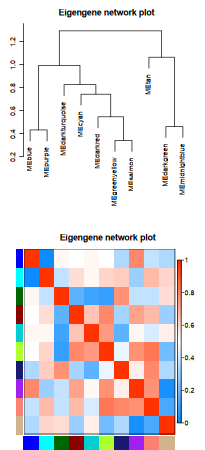

In [43]:
options(repr.plot.width=4.1, repr.plot.height=9, repr.plot.res = 50)

# Set up the font family and size
par(family = "Arial", cex = 0.8)

MEList = moduleEigengenes(dataExpr, colors = moduleColors)
MEs = MEList$eigengenes

# Plot with the specified font settings
plotEigengeneNetworks(MEs, "Eigengene network plot", marDendro = c(2,3 ,3,2), marHeatmap = c(2, 3, 3, 2))

# Save the plot to a PDF file with the specified font settings
pdf(file = paste0(plots_path, 'ME_tree_' ,Sys.time(), '.pdf'),  wi = 3.1, he = 7.3, family = "Arial")
par(cex = 0.8)  # Set the font size to 8 points in the PDF device
plotEigengeneNetworks(MEs, "", marDendro = c(2,3 ,3,2), marHeatmap = c(2, 3, 3, 2))
dev.off()


## Export Merged Moduels for Cytoscape

In [44]:
moduleColors %>% unique()

[1] "cyan"          "purple"        "blue"          "darkred"      
 [5] "midnightblue"  "salmon"        "darkturquoise" "greenyellow"  
 [9] "darkgreen"     "tan"

In [45]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
# Select modules
modules = c('purple','darkred','midnightblue','salmon',
            'darkturquoise','greenyellow','darkgreen','tan')
# Select module probes
probes = names(dataExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = modProbes
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];

dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(node_edge_path, '/', "edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, '/', "nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [46]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
# Select modules
modules = moduleColors %>% unique()
# Select module probes
probes = names(dataExpr)
inModule = is.finite(match(moduleColors, modules));
modProbes = probes[inModule];
modGenes = modProbes
# Select the corresponding Topological Overlap
modTOM = TOM[inModule, inModule];

dimnames(modTOM) = list(modProbes, modProbes)
# Export the network into edge and node list files Cytoscape can read
cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(node_edge_path, '/', "edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, '/', "nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


## edges and nodes of top n each module 

In [47]:
top_50_each_module_edge <- cyt[[1]] %>% semi_join(top_50_each_module, by = c('fromNode' = 'gene')) %>% 
    semi_join(top_50_each_module, by = c('toNode' = 'gene'))
top_50_each_module_edge %>%    write.csv(paste0(node_edge_path, '/', "edges-",'top50_each_module', ".csv"), row.names = F, quote = F)

In [48]:
top_50_each_module_edge_node <- cyt[[2]] %>% semi_join(top_50_each_module, by = c('nodeName' = 'gene')) 

top_50_each_module_edge_node %>%
    write.csv(paste0(node_edge_path, '/', "nodes-",'top50_each_module', ".csv"), row.names = F, quote = F)

In [49]:
connectivity_table %>% group_by(module) %>% top_n(5, wt = connectivity_rowSums_adj) %>% 
    mutate(hub = 'yes') %>% write.csv(paste0(node_edge_path, '/', "5hub_each_module.csv"), row.names = F, quote = F)

In [50]:
# Recalculate topological overlap if needed
TOM = TOMsimilarityFromExpr(dataExpr, power = 6);
threshold_ = 0.01
node_edge_path <- paste0(WGCNA_export_path, '/', threshold_, 'edge_node' , '/')
create_directory_if_not_exists(node_edge_path)
for (color in moduleColors %>% unique()) {
    if (color == 'grey') {
        next }
    # Select modules
    modules = color
    # Select module probes
    probes = names(dataExpr)
    inModule = is.finite(match(moduleColors, modules));
    modProbes = probes[inModule];
    modGenes = modProbes
    # Select the corresponding Topological Overlap
    modTOM = TOM[inModule, inModule];

    dimnames(modTOM) = list(modProbes, modProbes)
    # Export the network into edge and node list files Cytoscape can read
    cyt = exportNetworkToCytoscape(modTOM,
    edgeFile = paste(  node_edge_path, color,'-', threshold_,  "-edges-", paste(modules, collapse="-"), ".txt", sep=""),
    nodeFile = paste(node_edge_path, color, '-', threshold_, "-nodes-", paste(modules, collapse="-"), ".txt", sep=""),
    weighted = TRUE,
    threshold = threshold_ ,
    nodeNames = modProbes,
    altNodeNames = modGenes,
    nodeAttr = moduleColors[inModule])
}

TOM calculation: adjacency..
..will use 127 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [51]:
create_directory_if_not_exists(WGCNA_export_path)

In [52]:
cyt_merged_0 = exportNetworkToCytoscape(TOM,
             edgeFile = paste(WGCNA_export_path,  "/0_all_mdoules_edges.txt", sep=""),
             nodeFile = paste(WGCNA_export_path, "/0_all_mdoules_nodes.txt", sep=""),
             weighted = TRUE, threshold = 0,
             nodeNames = probes, nodeAttr = moduleColors)
node_data <- cyt_merged_0$nodeData[, c(1,3)]
names(node_data) <- c('gene', 'module')
nrow(node_data)
node_data %>% sample_n(2)

[1] 5454

gene      module
1 AT1G63830 cyan  
2 AT1G68840 cyan

In [53]:
node_n <- node_data %>% group_by(module) %>% summarise(n= n()) %>% mutate(module = paste0('ME', module))

## Module-trait relationships

In [54]:
traits <-readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')
traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 
    `DM1/DM2d` = case_when(
  group2 %in% c("DM1/DM2d") ~ 1,
  group2 %in% c("Col-0_12") ~ -1), 
    
    `DM6/DM7` = case_when(
  group2 %in% c("DM6/DM7") ~ 1,
  group2 %in% c("Col-0_14") ~ -1),    
    
    `2DMs_vs_WT` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12") ~ -1), 
    
    `DM1_DM2d_adr1s` = case_when(
  group2 %in% c( "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("Col-0_12" ) ~ -1), 
    
    `DM1_DM2d_adr1s` = case_when(
  group2 %in% c("DM6/DM7_adr1s" ) ~ 1,
  group2 %in% c("Col-0_14" ) ~ -1), 
    
    `Col-0_adr1s` = case_when(
  group2 %in% c("Col-0_adr1s" ) ~ 1,
  group2 %in% c("Col-0_12" ) ~ -1), 
    
    `DM1/DM2d_vs_DM6/DM7`  = case_when(
  group2 %in% c("DM1/DM2d" ) ~ 1,
  group2 %in% c("DM6/DM7" ) ~ -1), 
    
    `DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`  = case_when(
  group2 %in% c("DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7_adr1s" ) ~ -1), 

     `DM_adr1s_vs_Col-0_adr1s` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c('Col-0_adr1s' ) ~ -1), 

    
    `2adr1s_vs_WT` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12" ) ~ -1), 
    
     `3adr1s_vs_WT` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s", 'Col-0_adr1s') ~ 1,
  group2 %in% c("Col-0_14", "Col-0_12" ) ~ -1), 

     `2adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1), 
    
     `3adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s", 'Col-0_adr1s' ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1)
    
) 

traitData <- traits  %>%  dplyr::select(`DM1/DM2d`,`DM6/DM7`,`2DMs_vs_WT`,`DM1_DM2d_adr1s`,
        DM1_DM2d_adr1s,`Col-0_adr1s`,`2adr1s_vs_WT`,
    `3adr1s_vs_WT`,`2adr1s_vs_DM`,`3adr1s_vs_DM`,
        `DM1/DM2d_vs_DM6/DM7`,`DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`, `DM_adr1s_vs_Col-0_adr1s`,
                                 DAS) #%>% filter(!grepl('Tuescha|Cdm|DM11', rownames(traits)))


traitData

DM1/DM2d DM6/DM7 2DMs_vs_WT DM1_DM2d_adr1s Col-0_adr1s 2adr1s_vs_WT
DM1/DM2d_1   1       NA       1         NA             NA          NA          
Col-0_12_1  -1       NA      -1         NA             -1          -1          
DM1/DM2d_2   1       NA       1         NA             NA          NA          
Col-0_12_2  -1       NA      -1         NA             -1          -1          
DM1/DM2d_3   1       NA       1         NA             NA          NA          
DM6/DM7_1   NA        1       1         NA             NA          NA          
Col-0_14_1  NA       -1      -1         -1             NA          -1          
DM6/DM7_2   NA        1       1         NA             NA          NA          
Col-0_14_2  NA       -1      -1         -1             NA          -1          
DM6/DM7_3   NA        1       1         NA             NA          NA          
Col-0_14_3  NA       -1      -1         -1             NA          -1          
DM10/DM11_6 NA       NA      NA         NA             NA          NA          
DM10/DM11_5 NA       NA      NA         NA             NA          NA          
DM10/DM11_4 NA       NA      NA         NA             NA          NA          
DM10/DM11_3 NA       NA      NA         NA             NA          NA          
DM10/DM11_2 NA       NA      NA         NA             NA          NA          
DM10/DM11_1 NA       NA      NA         NA             NA          NA          
Tuescha-9_6 NA       NA      NA         NA             NA          NA          
Tuescha-9_5 NA       NA      NA         NA             NA          NA          
Tuescha-9_4 NA       NA      NA         NA             NA          NA          
Tuescha-9_3 NA       NA      NA         NA             NA          NA          
Tuescha-9_2 NA       NA      NA         NA             NA          NA          
Tuescha-9_1 NA       NA      NA         NA             NA          NA          
Cdm-0_6     NA       NA      NA         NA             NA          NA          
Cdm-0_5     NA       NA      NA         NA             NA          NA          
Cdm-0_4     NA       NA      NA         NA             NA          NA          
Cdm-0_3     NA       NA      NA         NA             NA          NA          
Cdm-0_2     NA       NA      NA         NA             NA          NA          
Cdm-0_1     NA       NA      NA         NA             NA          NA          
C12-1       -1       NA      -1         NA             -1          -1          
⋮           ⋮        ⋮       ⋮          ⋮              ⋮           ⋮           
C-A         NA       NA      NA         NA             NA          NA          
C-B         NA       NA      NA         NA             NA          NA          
C-C         NA       NA      NA         NA             NA          NA          
M6-A        NA       NA      NA         NA             NA          NA          
M6-B        NA       NA      NA         NA             NA          NA          
M6-C        NA       NA      NA         NA             NA          NA          
R6-A        NA       NA      NA         NA             NA          NA          
R6-B        NA       NA      NA         NA             NA          NA          
R6-C        NA       NA      NA         NA             NA          NA          
S6-A        NA       NA      NA         NA             NA          NA          
S6-B        NA       NA      NA         NA             NA          NA          
S6-C        NA       NA      NA         NA             NA          NA          
M12-A       NA       NA      NA         NA             NA          NA          
M12-B       NA       NA      NA         NA             NA          NA          
M12-C       NA       NA      NA         NA             NA          NA          
R12-A       NA       NA      NA         NA             NA          NA          
R12-B       NA       NA      NA         NA             NA          NA          
R12-C       NA       NA      NA         NA             NA          NA          
S12-A       

In [55]:
readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')

short_name  sample_Names     genotype tissue DM        DAS accession media
1  DM1/DM2d_1  DM1/DM2d_Shoot_1 DM       Shoot  DM1/DM2d  12  Col-0     1/2MS
2  Col-0_12_1  Col-0_Shoot_1    WT       Shoot  WT        12  Col-0     1/2MS
3  DM1/DM2d_2  DM1/DM2d_Shoot_2 DM       Shoot  DM1/DM2d  12  Col-0     1/2MS
4  Col-0_12_2  Col-0_Shoot_2    WT       Shoot  WT        12  Col-0     1/2MS
5  DM1/DM2d_3  DM1/DM2d_Shoot_3 DM       Shoot  DM1/DM2d  12  Col-0     1/2MS
6  DM6/DM7_1   DM6/DM7_Shoot_1  DM       Shoot  DM6/DM7   14  Col-0     1/2MS
7  Col-0_14_1  Col-0_Shoot_1    WT       Shoot  WT        14  Col-0     1/2MS
8  DM6/DM7_2   DM6/DM7_Shoot_2  DM       Shoot  DM6/DM7   14  Col-0     1/2MS
9  Col-0_14_2  Col-0_Shoot_2    WT       Shoot  WT        14  Col-0     1/2MS
10 DM6/DM7_3   DM6/DM7_Shoot_3  DM       Shoot  DM6/DM7   14  Col-0     1/2MS
11 Col-0_14_3  Col-0_Shoot_3    WT       Shoot  WT        14  Col-0     1/2MS
12 DM10/DM11_6 DM10/DM11_6      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
13 DM10/DM11_5 DM10/DM11_5      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
14 DM10/DM11_4 DM10/DM11_4      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
15 DM10/DM11_3 DM10/DM11_3      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
16 DM10/DM11_2 DM10/DM11_2      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
17 DM10/DM11_1 DM10/DM11_1      DM       Shoot  DM10/DM11 10  DM10/DM11 Soil 
18 Tuescha-9_6 Tuescha-9_6      WT       Shoot  WT        10  Tuescha-9 Soil 
19 Tuescha-9_5 Tuescha-9_5      WT       Shoot  WT        10  Tuescha-9 Soil 
20 Tuescha-9_4 Tuescha-9_4      WT       Shoot  WT        10  Tuescha-9 Soil 
21 Tuescha-9_3 Tuescha-9_3      WT       Shoot  WT        10  Tuescha-9 Soil 
22 Tuescha-9_2 Tuescha-9_2      WT       Shoot  WT        10  Tuescha-9 Soil 
23 Tuescha-9_1 Tuescha-9_1      WT       Shoot  WT        10  Tuescha-9 Soil 
24 Cdm-0_6     Cdm-0_6          WT       Shoot  WT        10  Cdm-0     Soil 
25 Cdm-0_5     Cdm-0_5          WT       Shoot  WT        10  Cdm-0     Soil 
26 Cdm-0_4     Cdm-0_4          WT       Shoot  WT        10  Cdm-0     Soil 
27 Cdm-0_3     Cdm-0_3          WT       Shoot  WT        10  Cdm-0     Soil 
28 Cdm-0_2     Cdm-0_2          WT       Shoot  WT        10  Cdm-0     Soil 
29 Cdm-0_1     Cdm-0_1          WT       Shoot  WT        10  Cdm-0     Soil 
30 C12-1       Col-0_12_1       WT       Shoot  WT        12  Col-0     1/2MS
⋮  ⋮           ⋮                ⋮        ⋮      ⋮         ⋮   ⋮         ⋮    
42 C-A         C-A              WT       Shoot  WT        12  Col-0     1/2MS
43 C-B         C-B              WT       Shoot  WT        12  Col-0     1/2MS
44 C-C         C-C              WT       Shoot  WT        12  Col-0     1/2MS
45 M6-A        M6-A             WT       Shoot  WT        12  Col-0     1/2MS
46 M6-B        M6-B             WT       Shoot  WT        12  Col-0     1/2MS
47 M6-C        M6-C             WT       Shoot  WT        12  Col-0     1/2MS
48 R6-A        R6-A             WT       Shoot  WT        12  Col-0     1/2MS
49 R6-B        R6-B             WT       Shoot  WT        12  Col-0     1/2MS
50 R6-C        R6-C             WT       Shoot  WT        12  Col-0     1/2MS
51 S6-A        S6-A             WT       Shoot  WT        12  Col-0     1/2MS
52 S6-B        S6-B             WT       Shoot  WT        12  Col-0     1/2MS
53 S6-C        S6-C             WT       Shoot  WT        12  Col-0     1/2MS
54 M12-A       M12-A            WT       Shoot  WT        12  Col-0     1/2MS
55 M12-B       M12-B            WT       Shoot  WT        12  Col-0     1/2MS
56 M12-C       M12-C            WT       Shoot  WT        12  Col-0     1/2MS
57 R12-A       R12-A            WT       Shoot  WT        12  Col-0     1/2MS
58 R12-B       R12-B            WT       Shoot  WT        12  Col-0     1/2MS
59 R12-C       R12-C            WT       Shoot  WT        12  Col-0     1/2MS
60 S12-A       S12-A            WT       Shoot  WT        12  Col-0     1/2MS
61 S12-B       S12-B     

In [56]:
traits <-readxl::read_excel("./refs/3-DM_shoots_root_JC14_adr1s_pathogen.xlsx") %>% filter(tissue =='Shoot')
traits <- traits %>% tibble::column_to_rownames( var = "short_name")  %>%  mutate( 

    `Rps4_vs_Rpt2_20h`  = case_when(
  group2 %in% c( "AvrRps4-20h") ~ 1,
  group2 %in% c("AvrRpt2-20h" ) ~ -1), 
    
  #   `Avr_vs_DM6/DM7_DM1/DM2d`  = case_when(
  # group2 %in% c("AvrRps4-20h",'AvrRpt2-20h' ) ~ 1,
  # group2 %in% c("DM1/DM2d", 'DM6/DM7') ~ -1), 
    
    `DM1/DM2d_vs_DM6/DM7`  = case_when(
  group2 %in% c("DM1/DM2d" ) ~ 1,
  group2 %in% c("DM6/DM7" ) ~ -1), 
    
    `DM1/DM2d_adr1s_vs_DM6/DM7_adr1s`  = case_when(
  group2 %in% c("DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7_adr1s" ) ~ -1), 

     `2adr1s_vs_DM` = case_when(
  group2 %in% c("DM6/DM7_adr1s", "DM1/DM2d_adr1s" ) ~ 1,
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ -1), 
    
    `DM_vs_WT` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c('Col-0_14', 'Col-0_12') ~ -1), 
    
        `Avr_vs_Mock` = case_when(
  group2 %in% c("AvrRps4-20h", "AvrRpt2-20h") ~ 1,
  group2 %in% c('Mock-20h' ) ~ -1), 
    
    `DM_vs_Avr` = case_when(
  group2 %in% c("DM6/DM7", "DM1/DM2d" ) ~ 1,
  group2 %in% c("AvrRps4-20h", "AvrRpt2-20h") ~ -1), 
      
    
    
) 

traitData <- traits  %>%  dplyr::select(18:ncol(traits))


traitData

Rps4_vs_Rpt2_20h DM1/DM2d_vs_DM6/DM7
DM1/DM2d_1  NA                1                 
Col-0_12_1  NA               NA                 
DM1/DM2d_2  NA                1                 
Col-0_12_2  NA               NA                 
DM1/DM2d_3  NA                1                 
DM6/DM7_1   NA               -1                 
Col-0_14_1  NA               NA                 
DM6/DM7_2   NA               -1                 
Col-0_14_2  NA               NA                 
DM6/DM7_3   NA               -1                 
Col-0_14_3  NA               NA                 
DM10/DM11_6 NA               NA                 
DM10/DM11_5 NA               NA                 
DM10/DM11_4 NA               NA                 
DM10/DM11_3 NA               NA                 
DM10/DM11_2 NA               NA                 
DM10/DM11_1 NA               NA                 
Tuescha-9_6 NA               NA                 
Tuescha-9_5 NA               NA                 
Tuescha-9_4 NA               NA                 
Tuescha-9_3 NA               NA                 
Tuescha-9_2 NA               NA                 
Tuescha-9_1 NA               NA                 
Cdm-0_6     NA               NA                 
Cdm-0_5     NA               NA                 
Cdm-0_4     NA               NA                 
Cdm-0_3     NA               NA                 
Cdm-0_2     NA               NA                 
Cdm-0_1     NA               NA                 
C12-1       NA               NA                 
⋮           ⋮                ⋮                  
C-A         NA               NA                 
C-B         NA               NA                 
C-C         NA               NA                 
M6-A        NA               NA                 
M6-B        NA               NA                 
M6-C        NA               NA                 
R6-A        NA               NA                 
R6-B        NA               NA                 
R6-C        NA               NA                 
S6-A        NA               NA                 
S6-B        NA               NA                 
S6-C        NA               NA                 
M12-A       NA               NA                 
M12-B       NA               NA                 
M12-C       NA               NA                 
R12-A       NA               NA                 
R12-B       NA               NA                 
R12-C       NA               NA                 
S12-A       NA               NA                 
S12-B       NA               NA                 
S12-C       NA               NA                 
M20-A       NA               NA                 
M20-B       NA               NA                 
M20-C       NA               NA                 
R20-A       -1               NA                 
R20-B       -1               NA                 
R20-C       -1               NA                 
S20-A        1               NA                 
S20-B        1               NA                 
S20-C        1               NA                 
            DM1/DM2d_adr1s_vs_DM6/DM7_adr1s 2adr1s_vs_DM DM_vs_WT Avr_vs_Mock
DM1/DM2d_1  NA                              -1            1       NA         
Col-0_12_1  NA                              NA           -1       NA         
DM1/DM2d_2  NA                              -1            1       NA         
Col-0_12_2  NA                              NA           -1       NA         
DM1/DM2d_3  NA                              -1            1       NA         
DM6/DM7_1   NA                              -1            1       NA         
Col-0_14_1  NA                              NA           -1       NA         
DM6/DM7_2   NA                              -1            1       NA         
Col-0_14_2  NA                              NA           -1       NA         
DM6/DM7_3   NA                              -1            1       NA         
Col-0_14_3  NA                              NA           -1       NA         
DM10/DM11_6 NA                        

In [57]:
rownames(MEs)

[1] "DM1/DM2d_1"  "Col-0_12_1"  "DM1/DM2d_2"  "Col-0_12_2"  "DM1/DM2d_3" 
 [6] "DM6/DM7_1"   "Col-0_14_1"  "DM6/DM7_2"   "Col-0_14_2"  "DM6/DM7_3"  
[11] "Col-0_14_3"  "DM10/DM11_6" "DM10/DM11_5" "DM10/DM11_4" "DM10/DM11_3"
[16] "DM10/DM11_2" "DM10/DM11_1" "Tuescha-9_6" "Tuescha-9_5" "Tuescha-9_4"
[21] "Tuescha-9_3" "Tuescha-9_2" "Tuescha-9_1" "Cdm-0_6"     "Cdm-0_5"    
[26] "Cdm-0_4"     "Cdm-0_3"     "Cdm-0_2"     "Cdm-0_1"     "C12-1"      
[31] "C12-2"       "C14-1"       "DJ-1"        "DJ-2"        "DJ-3"       
[36] "CJ-1"        "CJ-2"        "CJ-3"        "OJ-1"        "OJ-2"       
[41] "OJ-3"        "C-A"         "C-B"         "C-C"         "M6-A"       
[46] "M6-B"        "M6-C"        "R6-A"        "R6-B"        "R6-C"       
[51] "S6-A"        "S6-B"        "S6-C"        "M12-A"       "M12-B"      
[56] "M12-C"       "R12-A"       "R12-B"       "R12-C"       "S12-A"      
[61] "S12-B"       "S12-C"       "M20-A"       "M20-B"       "M20-C"      
[66] "R20-A"       "R20-B"       "R20-C"       "S20-A"       "S20-B"      
[71] "S20-C"

In [58]:
MEs %>% nrow
# rownames(MEs)
# rownames(traitData)
all(rownames(MEs) == rownames(traitData))

[1] 71

[1] TRUE

In [59]:
# Correlate traits --------------------------------------------------------
options(repr.plot.width=20, repr.plot.height=12, repr.plot.res = 140)
 
#Define number of genes and samples
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
#Recalculate MEs with color labels
MEs0 = moduleEigengenes(dataExpr, moduleColors)$eigengenes
MEs = orderMEs(MEs0)
moduleTraitCor = cor(MEs, traitData, use= "p")
moduleTraitPvalue = corPvalueStudent(moduleTraitCor, nSamples)

 
#Print correlation heatmap between modules and traits
textMatrix= paste(signif(moduleTraitCor, 2), "\n(",
                        signif(moduleTraitPvalue, 1), ")", sep= "")
dim(textMatrix)= dim(moduleTraitCor)

# par(mar= c(9, 15, 3, 3))
# module_relationship_plot <- labeledHeatmap(Matrix= moduleTraitCor,
#             xLabels= names(traitData),
#             yLabels= names(MEs),
#             ySymbols= names(MEs),
#             colorLabels= FALSE,
#             colors= blueWhiteRed(20, gamma = 0.3, endSaturation = 0.3),
#             textMatrix= textMatrix,
#             setStdMargins= FALSE,
#             xLabelsAngle =35,
#             cex.text= 1,
#             zlim= c(-1,1),
#             main= paste("Module-trait relationships")
#                                           )

pdf(file = paste0(plots_path, "module_trait_merged.pdf"),  wi = 14, he = 9)

par(mar= c(9, 7, 3, 3))
module_relationship_plot <- labeledHeatmap(Matrix= moduleTraitCor,
            xLabels= names(traitData),
            yLabels= names(MEs),
            ySymbols= names(MEs),
            colorLabels= FALSE,
            colors= blueWhiteRed(20, gamma =0.3 , endSaturation = 0.3),
            textMatrix= textMatrix,
            setStdMargins= FALSE,
            xLabelsAngle =35,
            cex.text= 1,
            zlim= c(-1,1),
            main= paste("Module-trait relationships")
                                          )

dev.off()

png 
  2

In [60]:
names(traitData)

[1] "Rps4_vs_Rpt2_20h"                "DM1/DM2d_vs_DM6/DM7"            
[3] "DM1/DM2d_adr1s_vs_DM6/DM7_adr1s" "2adr1s_vs_DM"                   
[5] "DM_vs_WT"                        "Avr_vs_Mock"                    
[7] "DM_vs_Avr"

# customized trait plot

In [61]:
module_trait_df <- moduleTraitCor %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = 'Module') %>%
  pivot_longer(cols = -Module, names_to = 'Trait', values_to = 'Correlation') %>% 
    left_join(
        moduleTraitPvalue %>%
  as.data.frame() %>%
  tibble::rownames_to_column(var = 'Module') %>%
  pivot_longer(cols = -Module, names_to = 'Trait', values_to = 'Pvalue'),
    by = c('Module' = 'Module', 'Trait' = 'Trait')) %>% 
    mutate(Module = factor(Module, levels = c(rownames(moduleTraitCor))),
          colors = Module %>% str_remove('ME')) %>% mutate(Trait = factor(Trait, levels = names(traitData)))

In [62]:
module_trait_n  <- module_trait_df %>% dplyr::select(Module) %>% distinct %>% 
    left_join(node_n, by = c('Module' = 'module')) %>% mutate(Module = factor(Module, levels = c(rownames(moduleTraitCor))))
module_colors <- setNames(as.character(unique(module_trait_df$colors)), unique(module_trait_df$Module))

In [63]:
module_trait_n <- module_trait_n %>%
  mutate(Module_n = paste0(Module, '\nn=', n) ) %>% mutate(Module_n = factor(Module_n, levels = paste0(Module, '\nn=', n) ))

In [64]:
module_colors['MEyellow'] = '#e5e64c'
module_colors['MEred'] = '#e84646'

In [65]:
module_legend_grob2 <- ggplot(module_trait_n) +
    geom_tile(aes(x = 1, y = Module_n , fill = Module)) +
    scale_fill_manual(values = module_colors) +
    theme_classic() +
    theme(axis.line = element_blank(),
          axis.text.x = element_blank(),
          axis.text.y = element_text(size = 10),
          axis.ticks = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          legend.position = "none") +
    labs(y = "Module") +
    coord_cartesian(clip = "off")
module_legend_grob2 <- ggplotGrob(module_legend_grob2)
# module_legend_grob2 %>% plot

In [66]:
module_colors

MEblue        MEpurple MEdarkturquoise          MEcyan       MEdarkred 
         "blue"        "purple" "darkturquoise"          "cyan"       "darkred" 
  MEgreenyellow        MEsalmon           MEtan     MEdarkgreen  MEmidnightblue 
  "greenyellow"        "salmon"           "tan"     "darkgreen"  "midnightblue" 
       MEyellow           MEred 
      "#e5e64c"       "#e84646"

In [67]:
module_legend_grob2

TableGrob (12 x 9) "layout": 18 grobs
    z         cells       name                                       grob
1   0 ( 1-12, 1- 9) background             rect[plot.background..rect.35]
2   5 ( 6- 6, 4- 4)     spacer                             zeroGrob[NULL]
3   7 ( 7- 7, 4- 4)     axis-l         absoluteGrob[GRID.absoluteGrob.27]
4   3 ( 8- 8, 4- 4)     spacer                             zeroGrob[NULL]
5   6 ( 6- 6, 5- 5)     axis-t                             zeroGrob[NULL]
6   1 ( 7- 7, 5- 5)      panel                    gTree[panel-1.gTree.22]
7   9 ( 8- 8, 5- 5)     axis-b         absoluteGrob[GRID.absoluteGrob.23]
8   4 ( 6- 6, 6- 6)     spacer                             zeroGrob[NULL]
9   8 ( 7- 7, 6- 6)     axis-r                             zeroGrob[NULL]
10  2 ( 8- 8, 6- 6)     spacer                             zeroGrob[NULL]
11 10 ( 5- 5, 5- 5)     xlab-t                             zeroGrob[NULL]
12 11 ( 9- 9, 5- 5)     xlab-b zeroGrob[axis.title.x.bottom..zeroGrob.28]


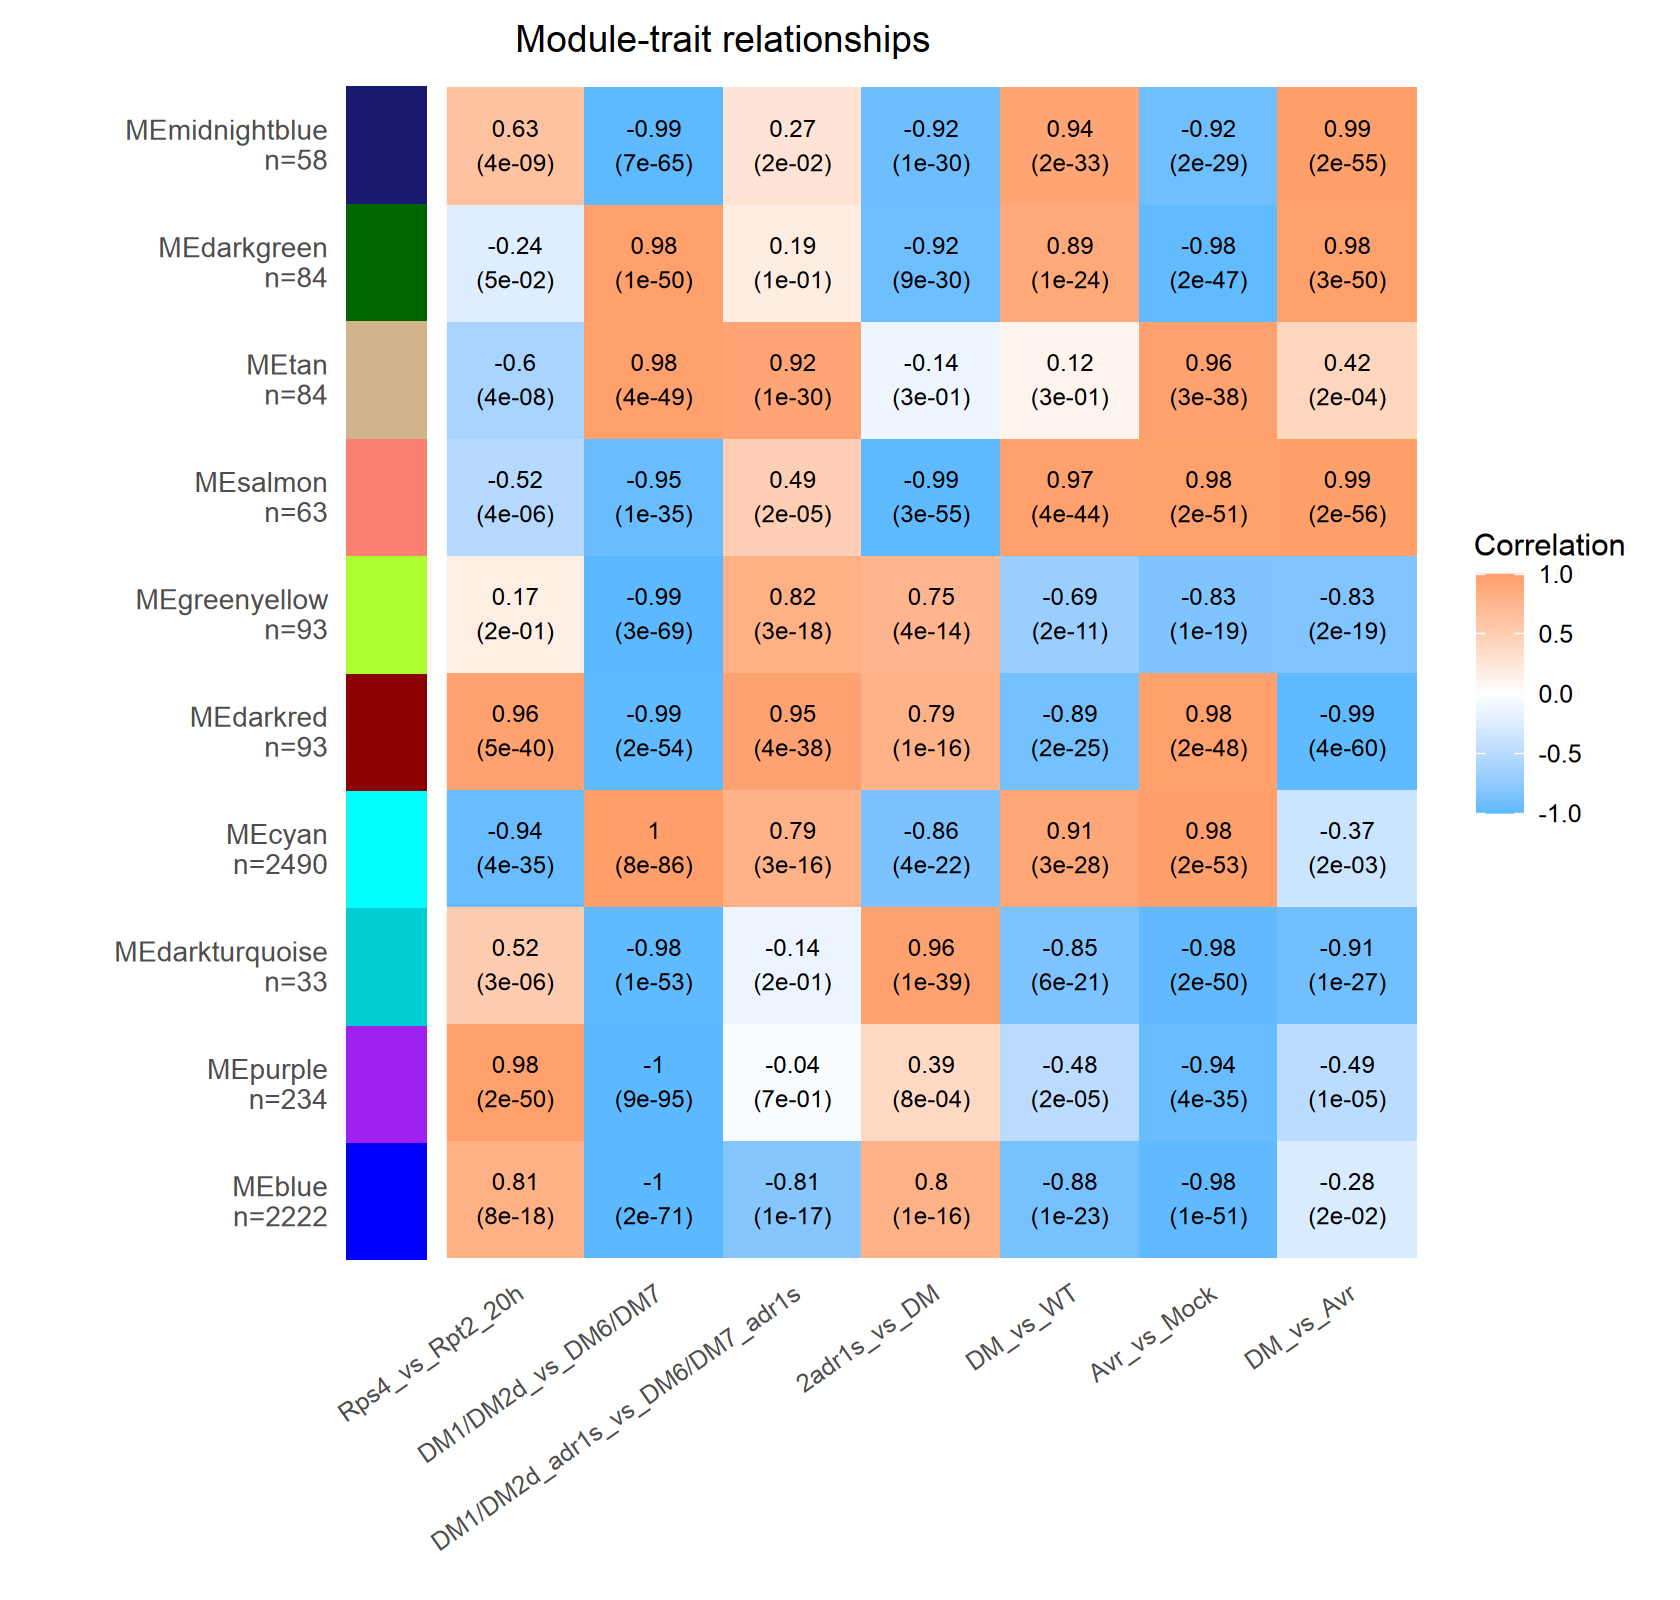

In [68]:
trait_plot_height = 8
trait_plot_width = 8.4
options(repr.plot.width=trait_plot_width, repr.plot.height= trait_plot_height, repr.plot.res = 200)
module_relationship_plot <- ggplot(module_trait_df, aes(x = Trait, y = Module, fill = Correlation)) +
  geom_tile() +
  geom_text(aes(label = paste0(round(Correlation, 2), "\n(", formatC(Pvalue, format = "e", digits = 0), ")")),
            size = 3, color = "black") +
  scale_fill_gradient2(low = "#5CB9FF", mid = "white", high = "#FF9E6A", midpoint = 0, limits = c(-1, 1),
                       guide = guide_colorbar(title = "Correlation", title.position = "top", title.hjust = 0.5)) +
  theme_classic() +
  theme(axis.text.x = element_text(angle = 35, hjust = 1),
        plot.title = element_text(hjust = 0.5),
        plot.margin = margin(9, 15, 3, 3, "pt")) +
  labs(x = "", y = "", title = "Module-trait relationships") +
  theme(axis.line  = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks = element_blank(),
        axis.title.y = element_blank()) +
  coord_cartesian(xlim = c(-2, length(unique(module_trait_df$Trait))), clip = 'off') +
  annotation_custom(grob = module_legend_grob2, xmin = -2, xmax = 0.5, ymin = 0.18, ymax = length(unique(module_trait_df$Module)) + 0.74)

module_relationship_plot
module_relationship_plot %>%  ggsave(file = paste0(plots_path, 'relationship', Sys.time(), '.pdf'), 
                    height = trait_plot_height, width = trait_plot_width)


In [69]:
node_data %>% filter(gene %in% c('AT5G49450', 'AT1G23380', 'AT5G65510'))

gene      module
1 AT5G49450 cyan

In [70]:
node_data %>% filter(module != 'grey')

gene      module      
1    AT1G69810 cyan        
2    AT1G52200 cyan        
3    AT1G71890 purple      
4    AT1G80870 blue        
5    AT1G47900 blue        
6    AT1G19715 blue        
7    AT1G53625 cyan        
8    AT1G51440 blue        
9    AT1G80840 cyan        
10   AT1G30640 cyan        
11   AT1G26440 cyan        
12   AT1G22070 cyan        
13   AT1G78180 blue        
14   AT1G06240 blue        
15   AT1G72330 cyan        
16   AT1G20840 cyan        
17   AT1G52400 darkred     
18   AT1G14880 midnightblue
19   AT1G34640 blue        
20   AT1G49430 blue        
21   AT1G65820 cyan        
22   AT1G35180 blue        
23   AT1G35210 cyan        
24   AT1G10410 cyan        
25   AT1G10522 blue        
26   AT1G67590 blue        
27   AT1G30530 purple      
28   AT1G44130 cyan        
29   AT1G08630 cyan        
30   AT1G66150 blue        
⋮    ⋮         ⋮           
5425 AT4G23170 cyan        
5426 AT4G38932 cyan        
5427 AT4G13493 blue        
5428 AT4G04223 darkgreen   
5429 AT4G12917 purple      
5430 AT4G13495 blue        
5431 AT4G36648 cyan        
5432 ATMG00030 cyan        
5433 ATMG01390 cyan        
5434 ATMG00020 cyan        
5435 ATCG01020 blue        
5436 ATCG00470 blue        
5437 ATCG00270 blue        
5438 ATCG00490 blue        
5439 ATCG00480 blue        
5440 ATCG00220 blue        
5441 ATCG00280 blue        
5442 ATCG00020 blue        
5443 ATCG00540 blue        
5444 ATCG00350 blue        
5445 ATCG00430 blue        
5446 ATCG00300 blue        
5447 ATCG00680 blue        
5448 ATCG00040 blue        
5449 ATCG00340 blue        
5450 ATCG00330 blue        
5451 ATCG01210 blue        
5452 ATCG00920 blue        
5453 ATCG01180 blue        
5454 ATCG00950 blue

In [71]:
node_data %>% pull(module) %>%unique

[1] "cyan"          "purple"        "blue"          "darkred"      
 [5] "midnightblue"  "salmon"        "darkturquoise" "greenyellow"  
 [9] "darkgreen"     "tan"

In [72]:
library('DOSE')
library("clusterProfiler")
library(gprofiler2)

DOSE v3.28.1  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


clusterProfiler v4.10.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter




In [73]:
# Split the data frame into a list of named sublists by module
module_lists <- split(node_data$gene, node_data$module)
module_lists$black %>% length

[1] 0

In [74]:
GOs = gost( module_lists,
      organism = "athaliana", sources = c("GO:BP", "GO:MF", "GO:CC", "KEGG"), multi_query = FALSE, evcodes = TRUE)

In [75]:
# Define the function to process g:Profiler data
process_gprofiler_data <- function(df, include_terms_pattern = NULL, apply_filter = TRUE, cluster_order = NULL) {
  # Select relevant columns from the input dataframe
  gp_mod <- df$result[, c("query", "source", "term_id",
                          "term_name", "p_value", "query_size", 
                          "intersection_size", "term_size", 
                          "effective_domain_size", "intersection")]
  
  # Calculate GeneRatio and BgRatio
  gp_mod$GeneRatio <- paste0(gp_mod$intersection_size, "/", gp_mod$query_size)
  gp_mod$BgRatio <- paste0(gp_mod$term_size, "/", gp_mod$effective_domain_size)
  
  # Rename columns
  names(gp_mod) <- c("Cluster", "Category", "ID", "Description", "p.adjust", 
                     "query_size", "Count", "term_size", "effective_domain_size", 
                     "geneID", "GeneRatio", "BgRatio")
  
  # Replace commas with slashes in geneID column
  gp_mod$geneID <- gsub(",", "/", gp_mod$geneID)
  
  # Apply filter based on include_terms_pattern if apply_filter is TRUE
  if (apply_filter && !is.null(include_terms_pattern)) {
    gp_mod <- gp_mod %>% filter(str_detect(Description, include_terms_pattern))
  }
  
  # Capitalize the first letter of each word in the Description column
  gp_mod$Description <- stringr::str_replace(gp_mod$Description, "^\\w", stringr::str_to_title)
  
  # Factorize the Cluster column based on the input list (cluster_order)
  if (!is.null(cluster_order)) {
    gp_mod$Cluster <- factor(gp_mod$Cluster, levels = cluster_order)
  }

  # Return the modified dataframe
  return(gp_mod)
}

# Usage example:

# Define the terms to include
include_terms <- c('systemic acquired resistance', 'response to salicylic acid', 'response to oxidative stress',
                  'programmed cell death', 'defense response', 'response to hypoxia', 'chitin metabolic process',
                  'aminoglycan metabolic process', 'response to toxic substance', 'hydrogen peroxide catabolic process',
                  'detoxification',
                  'secretory vesicle', 'plasma membrane', 'extracellular region',
                  'tetrapyrrole binding', 'polysaccharide binding', 'peroxidase activity',
                  'Starch and sucrose metabolism', 'Plant-pathogen interaction', 'Phenylpropanoid biosynthesis'
                  )


# Create the include_terms_pattern
include_terms_pattern <- paste0("^(", paste(include_terms, collapse = "|"), ")$")


# Define the list to order Cluster column
# cluster_order <- c("DM10/DM11", "DM1/DM2d", "DM6/DM7", "DM1/DM2d_adr1s", "DM6/DM7_adr1s", "Col-0_adr1s")

# Process the GO_up and GO_down dataframes using the process_gprofiler_data function
GO_result <- process_gprofiler_data(GOs, include_terms_pattern, apply_filter = F )


In [76]:
library(ggh4x)

In [77]:
GO_result %>% arrange(p.adjust)

Cluster      Category ID        
1   cyan         GO:BP    GO:0050896
2   blue         GO:CC    GO:0009507
3   cyan         GO:BP    GO:0006950
4   blue         GO:CC    GO:0009536
5   cyan         GO:BP    GO:0042221
6   blue         GO:CC    GO:0009579
7   blue         GO:CC    GO:0009526
8   blue         GO:CC    GO:0009534
9   blue         GO:CC    GO:0031976
10  blue         GO:CC    GO:0009532
11  blue         GO:CC    GO:0009570
12  cyan         GO:BP    GO:0036294
13  cyan         GO:BP    GO:0071453
14  cyan         GO:BP    GO:0071456
15  cyan         GO:BP    GO:0001666
16  cyan         GO:BP    GO:0036293
17  cyan         GO:BP    GO:0070482
18  cyan         GO:BP    GO:0044419
19  cyan         GO:BP    GO:0051707
20  cyan         GO:BP    GO:0043207
21  cyan         GO:BP    GO:0009607
22  blue         GO:CC    GO:0042651
23  blue         GO:CC    GO:0034357
24  blue         GO:CC    GO:0009535
25  blue         GO:CC    GO:0055035
26  cyan         GO:BP    GO:0009605
27  blue         GO:CC    GO:0042170
28  blue         GO:BP    GO:0015979
29  blue         GO:CC    GO:0031967
30  cyan         GO:BP    GO:0006952
⋮   ⋮            ⋮        ⋮         
905 cyan         GO:BP    GO:0042436
906 cyan         GO:MF    GO:0016810
907 tan          GO:BP    GO:0006351
908 blue         GO:BP    GO:0010817
909 cyan         GO:CC    GO:0000421
910 purple       GO:BP    GO:0009411
911 purple       GO:BP    GO:0010109
912 blue         GO:MF    GO:0097367
913 midnightblue GO:CC    GO:0005576
914 salmon       GO:CC    GO:0005576
915 cyan         GO:BP    GO:0062197
916 cyan         GO:MF    GO:0016758
917 cyan         GO:MF    GO:0030246
918 blue         GO:BP    GO:0042168
919 blue         GO:MF    GO:0032555
920 cyan         KEGG     KEGG:00071
921 purple       GO:MF    GO:0016491
922 tan          GO:BP    GO:0048583
923 blue         GO:BP    GO:1901657
924 purple       GO:BP    GO:0009987
925 blue         GO:BP    GO:0006783
926 tan          GO:BP    GO:0009889
927 cyan         GO:MF    GO:0015662
928 cyan         GO:BP    GO:0009411
929 purple       GO:CC    GO:0009579
930 cyan         GO:BP    GO:0030001
931 cyan         GO:MF    GO:1901149
932 cyan         GO:MF    GO:0016877
933 cyan         GO:BP    GO:0006066
934 blue         GO:CC    GO:0062091
    Description                                                              
1   Response to stimulus                                                     
2   Chloroplast                                                              
3   Response to stress                                                       
4   Plastid                                                                  
5   Response to chemical                                                     
6   Thylakoid                                                                
7   Plastid envelope                                                         
8   Chloroplast thylakoid                                                    
9   Plastid thylakoid                                                        
10  Plastid stroma                                                           
11  Chloroplast stroma                                                       
12  Cellular response to decreased oxygen levels                             
13  Cellular response to oxygen levels                                       
14  Cellular response to hypoxia                                             
15  Response to hypoxia                                                      
16  Response to decreased oxygen levels                                      
17  Response to oxygen levels                                                
18  Biological process involved in interspecies interaction between organisms
19  Response to other organism                                               
20  Response to external biotic stimulus                                     
21  Response to biotic stimulus                                         

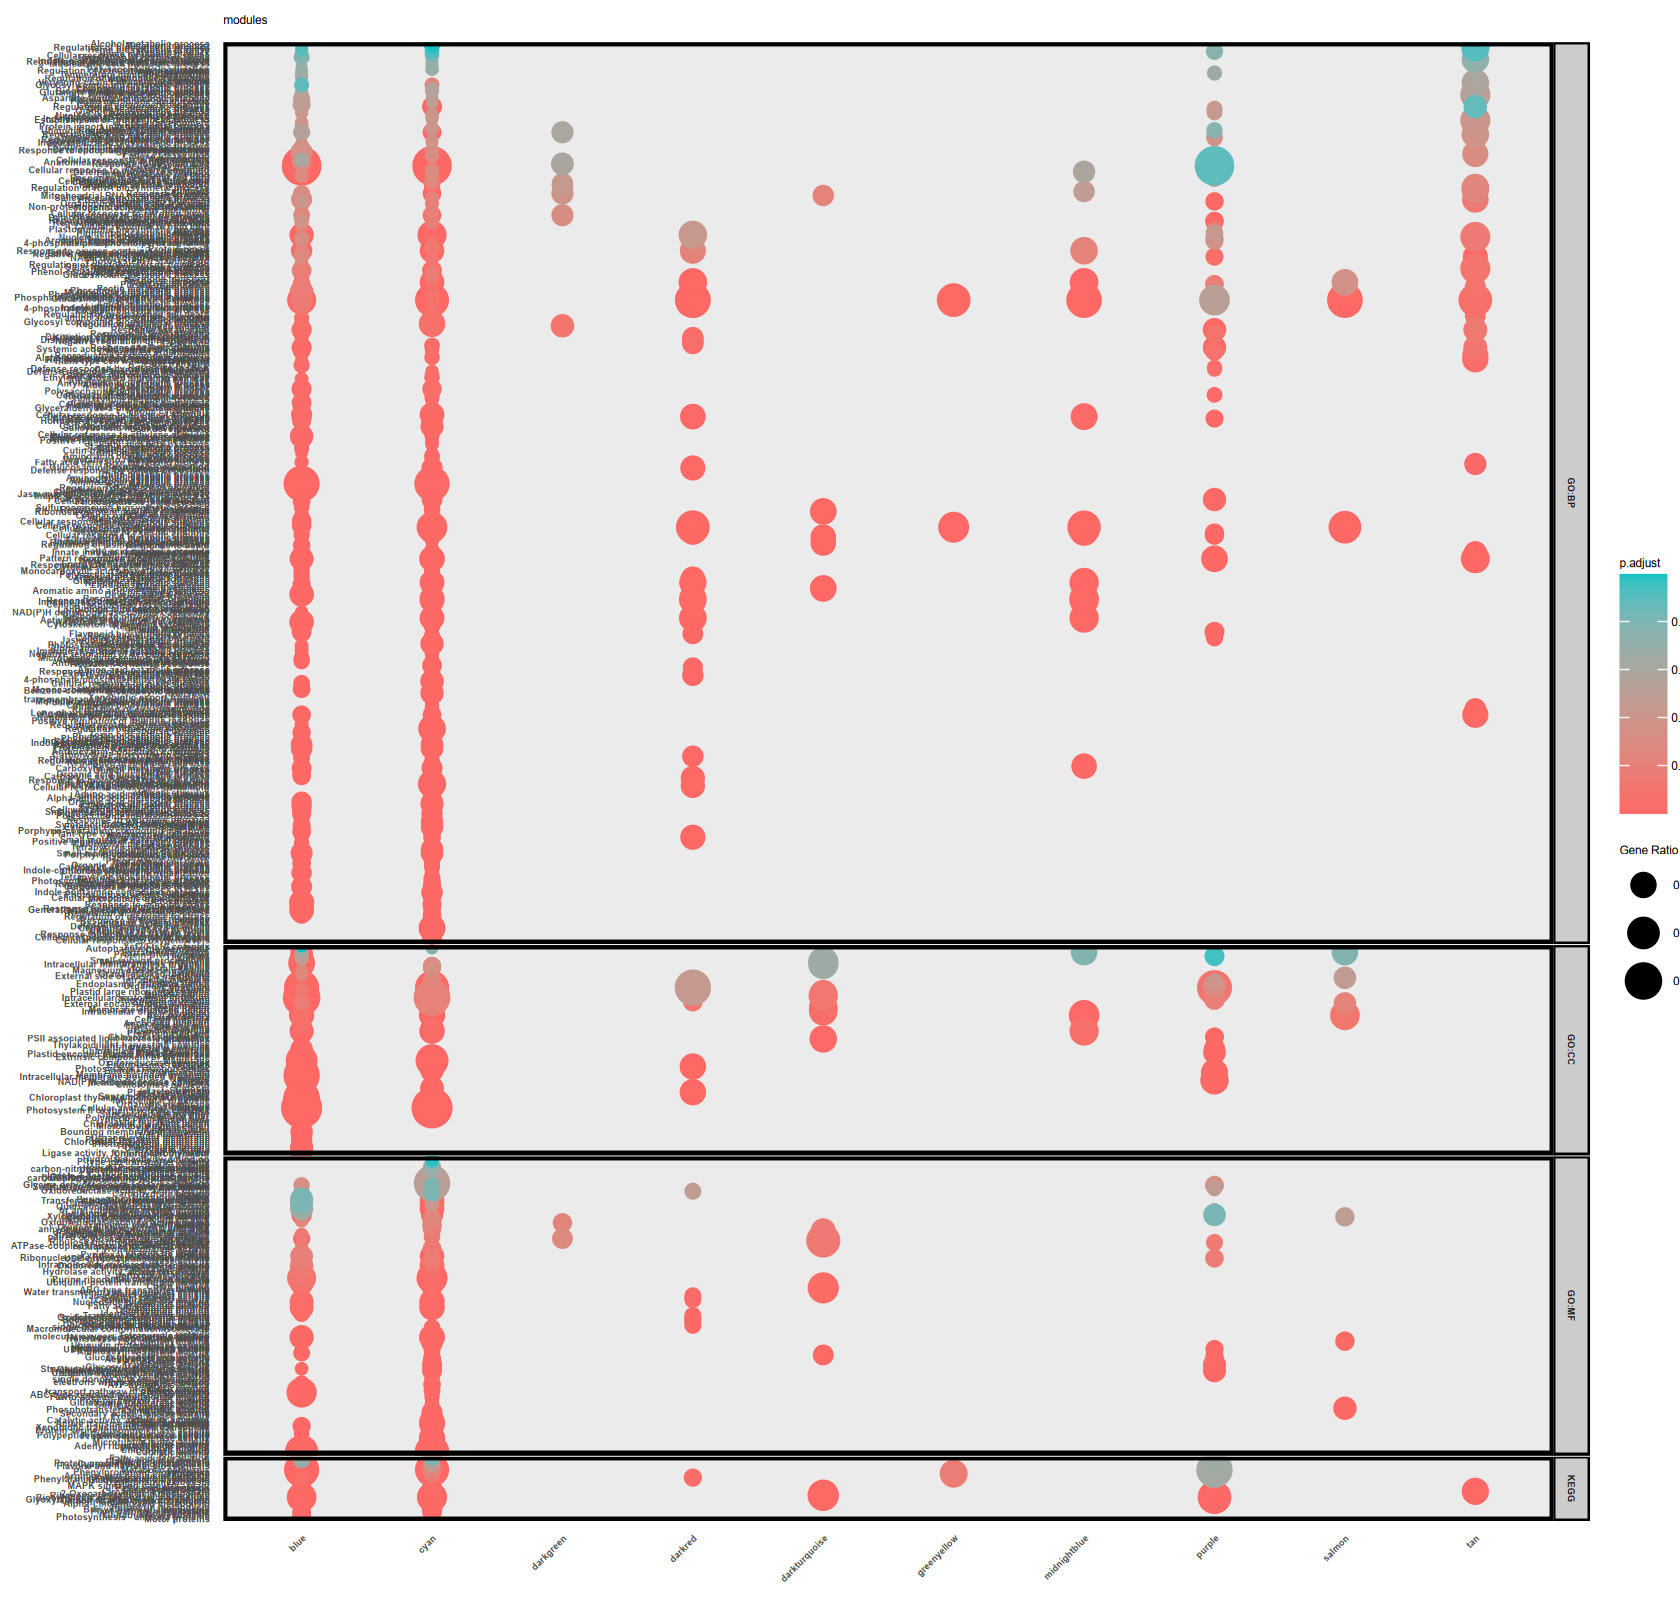

In [78]:
# Function to create a customized dot plot
customize_dotplot <- function(data,
                              description_width = 40,
                              low_color = "#fe6865",
                              high_color = "#0fc3c7",
                              text_size = 10,
                              panel_spacing_y = 0.05,
                              dodge_labels = FALSE,
                              plot_title = "Customized Dot Plot") {
  
  # Wrap the Description text to a fixed width
  data$Description <- str_wrap(data$Description, width = description_width)
  
  # Calculate the proportions of unique Descriptions for each Category
  category_proportions <- data %>%
    group_by(Category) %>%
    summarise(n_unique_descriptions = n_distinct(Description)) %>%
    mutate(proportion = n_unique_descriptions / sum(n_unique_descriptions)) %>%
    pull(proportion)
    
  # Create the customized dot plot
  go_plot <- ggplot(data, aes(x = Cluster, y = reorder(Description, `p.adjust`), size = Count/query_size, color = `p.adjust`)) +
    geom_point() +
    scale_color_gradient(low = low_color, high = high_color) +
    facet_grid(Category ~ . , scales = "free_y",
               labeller = label_wrap_gen(width = description_width, multi_line = T)) +
    labs(title = plot_title,
         x = NULL, # Remove x-axis title
         y = NULL, # Remove y-axis title
         size = "Gene Ratio",
         color = "p.adjust") +
    theme_minimal() +
    theme(
      text = element_text(size = text_size, color = "black"),
      plot.title = element_text(size = text_size, color = "black"), # Set plot title font size
      legend.text = element_text(size = text_size, color = "black"), # Set legend font size
      strip.background = element_rect(fill = "grey80"),
      panel.border = element_rect(colour = "black", fill = NA, linewidth = 1),
      panel.spacing.y = unit(panel_spacing_y, "lines"), # Set space between facets
      legend.margin = margin(0, -10, 0, 0), # Reduced space between legend and plot
      axis.text.y = element_text(face = "bold"), # Bold Description
      axis.text.x = element_text(face = "bold", angle = ifelse(dodge_labels, 45, 0), hjust = ifelse(dodge_labels, 1, 0.5), vjust = ifelse(dodge_labels, 1, 0.5)), # Bold Cluster with optional dodging
      strip.text.y = element_text(face = "bold") # Bold facet name
    ) + 
    guides(size = guide_legend(order = 0),
           color = guide_colourbar(order = 1)) +
    force_panelsizes(rows = category_proportions)
  
  return(go_plot)
}

# Call the function with the data object and dodge_labels set to TRUE
go_plot <- GO_result %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
# go_plot
go_plot


In [79]:
# Call the function with the data object and dodge_labels set to TRUE
go_plot <- GO_result %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
# go_plot

In [80]:
go_plot_list <- list()
for (i in GO_result %>% pull(Cluster) %>% unique) {
   GO_result %>% filter(Cluster == i) %>% customize_dotplot(plot_title = 'modules', text_size = 4, dodge_labels = TRUE)
}

In [81]:
# Create an empty list for storing the plots
go_plot_list <- list()

# Iterate through each unique value in the "cluster" column
for (i in unique(GO_result$Cluster)) {
  # Filter the data for the specific cluster value
  cluster_data <- GO_result %>% filter(Cluster == i)
  
  # Customize the dot plot and store it in a variable
  plot <- customize_dotplot(cluster_data, plot_title = 'modules', text_size = 8, dodge_labels = TRUE)
  
  # Append the plot to the go_plot_list
  go_plot_list[[paste0("Cluster_", i)]] <- plot
}


In [82]:
# Load necessary libraries
library(gridExtra)
library(grid)
# Arrange the plots from go_plot_list in a grid with the specified dimensions
combined_plot <- arrangeGrob(grobs = go_plot_list, ncol = 2, width =8.4)

# Display the combined plot
# grid.draw(combined_plot)
combined_plot %>% ggsave(file = paste0(plots_path, 'GO_', Sys.time(), '.pdf'), height = 40, width = 8)

In [83]:
node_data %>% mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor))) %>% filter(module == 'MEsalmon') %>% left_join(map_id_name, by= c('gene' = 'gene_id')) %>% pull(gene_name)

[1] "CCR1"       "GSR2"       "SNRK2-8"    "PUT1"       "AT1G33790" 
 [6] "ACO2"       "UMAMIT28"   "SULTR1;2"   "AT1G65985"  "STMP7"     
[11] "AT1G19380"  "AT1G52342"  "GH3.17"     "MT1C"       "AT1G76960" 
[16] "LTPG32"     "AT1G64850"  "PHI-1"      "GASA1"      "FTSH8"     
[21] "WRKY57"     "ANNAT2"     "VICTL"      "AT5G40910"  "PROSCOOP6" 
[26] "AT5G45500"  "SLAH3"      "AT5G38980"  "PROSCOOP10" "AT5G64110" 
[31] "PSK5"       "AT5G45490"  "AT5G46490"  "AT5G38940"  "DM2H"      
[36] "PPa4"       "CM1"        "BAM1"       "AAE7"       "RPP1"      
[41] "PAL2"       "AT3G44630"  "AT3G50570"  "scpl48"     "UMAMIT45"  
[46] "FLZ8"       "AT3G44100"  "SDR1"       "AT3G26590"  "AT2G32160" 
[51] "AT2G24600"  "LTP2"       "PRB1"       "NHL13"      "ARPN"      
[56] "AT4G29070"  "SNC1"       "UBQ11"      "YSL1"       "TN15"      
[61] "AT4G00955"  "sks9"       "CRK40"

In [84]:
formula_GO_BP <- compareCluster( gene ~ module ,data = node_data,# %>% as.data.frame, 
                              OrgDb = "org.At.tair.db", 
                              fun = "enrichGO", ont="BP",
                              keyType="TAIR")

simplified_GO_BP <- simplify(formula_GO_BP, 
                       cutoff=0.5, # smaller,fewer category  0.4
                       by="p.adjust", select_fun = min,
  measure = "Wang",)

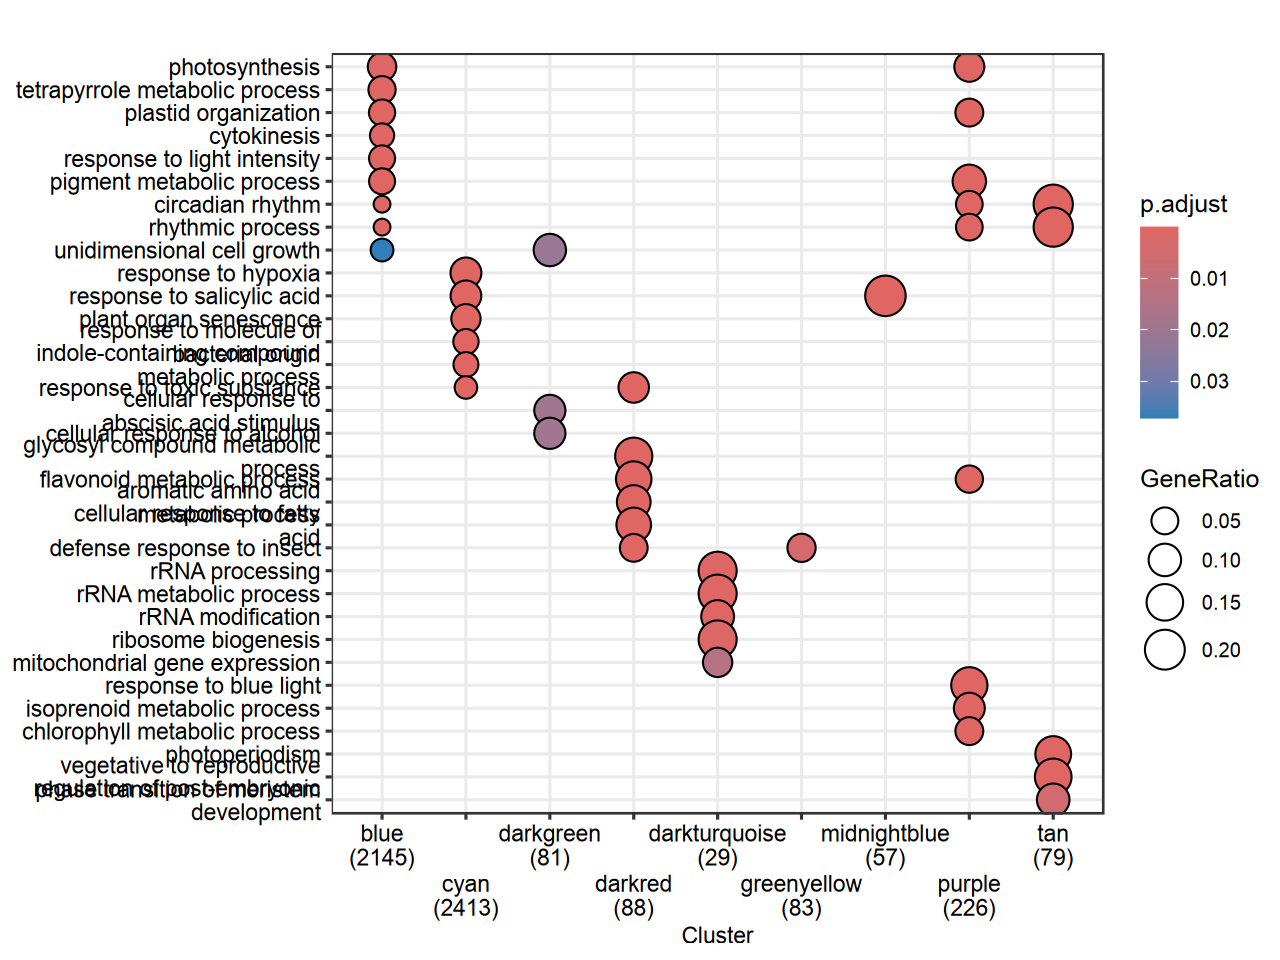

In [85]:
options(repr.plot.width=8, repr.plot.height=6, repr.plot.res = 160)

#somehow the levels of module is lost, level it again
GO_plot <- dotplot(simplified_GO_BP,
                   font.size = 10) + scale_x_discrete(guide = guide_axis(n.dodge = 2)) #+ theme_Publication()
GO_plot %>% ggsave(file = paste0(plots_path, "wgcna_GO_plot_2.pdf"), width=8, height=8)
GO_plot

# heatmap

In [86]:
Res_combined <- readRDS('./Rdata/Res_combined.rds')
Res_combined

AGI       log2FC      source        
1      AT1G30814  5.18459620 DM6/DM7       
2      AT1G78930  0.01991274 DM6/DM7       
3      AT1G71695 -2.30890364 DM6/DM7       
4      AT1G58983 -0.17951020 DM6/DM7       
5      AT1G12980  2.27948272 DM6/DM7       
6      AT1G56250  0.77412597 DM6/DM7       
7      AT1G66852  0.00000000 DM6/DM7       
8      AT1G69810  2.76176191 DM6/DM7       
9      AT1G72450 -0.41945456 DM6/DM7       
10     AT1G76280 -0.42485352 DM6/DM7       
11     AT1G65630 -2.65909162 DM6/DM7       
12     AT1G71390  4.94242971 DM6/DM7       
13     AT1G15210  0.15281775 DM6/DM7       
14     AT1G15250 -0.25189140 DM6/DM7       
15     AT1G79700 -0.10009903 DM6/DM7       
16     AT1G73360 -3.95462558 DM6/DM7       
17     AT1G16360 -1.35935929 DM6/DM7       
18     AT1G10225 -0.59364808 DM6/DM7       
19     AT1G26670  0.60329926 DM6/DM7       
20     AT1G52200  3.54791726 DM6/DM7       
21     AT1G57800  0.00000000 DM6/DM7       
22     AT1G69460  0.23281495 DM6/DM7       
23     AT1G04310 -0.53626527 DM6/DM7       
24     AT1G08080 -3.34879101 DM6/DM7       
25     AT1G75550 -3.24048831 DM6/DM7       
26     AT1G71890  0.19682873 DM6/DM7       
27     AT1G05430  0.20292319 DM6/DM7       
28     AT1G80870  0.69900541 DM6/DM7       
29     AT1G75310  0.19755597 DM6/DM7       
30     AT1G02010 -0.93473861 DM6/DM7       
⋮      ⋮         ⋮           ⋮             
311701 AT3G44460 -14.49592   Col-0_adr1s   
311702 ATMG01275 -14.57193   Col-0_adr1s   
311703 AT3G01313 -14.73614   Col-0_adr1s   
311704 ATMG00290 -15.22105   Col-0_adr1s   
311705 ATCG00905 -15.32369   Col-0_adr1s   
311706 ATCG00250 -15.36171   Col-0_adr1s   
311707 AT3G04975 -15.46356   Col-0_adr1s   
311708 AT3G19350 -15.60237   Col-0_adr1s   
311709 AT5G44310 -15.79518   Col-0_adr1s   
311710 AT3G13433 -15.79653   Col-0_adr1s   
311711 ATMG00720 -16.23952   Col-0_adr1s   
311712 AT2G08820 -16.34987   Col-0_adr1s   
311713 AT2G42560 -16.45635   DM6/DM7_adr1s 
311714 AT5G22470 -17.92847   DM6/DM7_adr1s 
311715 AT3G03260 -17.95694   Col-0_adr1s   
311716 AT1G71000 -18.31402   Col-0_adr1s   
311717 AT3G17520 -18.57301   Col-0_adr1s   
311718 AT3G25240 -18.66534   Col-0_adr1s   
311719 AT2G17680 -18.78335   DM6/DM7_adr1s 
311720 AT4G27140 -19.96459   DM6/DM7_adr1s 
311721 AT3G24750 -20.62148   Col-0_adr1s   
311722 AT1G12610 -20.62553   DM1/DM2d_adr1s
311723 AT1G52690 -20.89255   Col-0_adr1s   
311724 AT3G11480 -22.09972   Col-0_adr1s   
311725 AT4G27150 -22.10308   Col-0_adr1s   
311726 AT5G44310 -25.53899   DM6/DM7_adr1s 
311727 AT4G21020 -30.52377   DM1/DM2d_adr1s
311728 AT1G04560 -31.02019   DM1/DM2d_adr1s
311729 AT1G72100 -41.98945   DM1/DM2d_adr1s
311730 AT1G75470 -44.02230   DM1/DM2d_adr1s

In [87]:
node_data 

gene      module      
1    AT1G69810 cyan        
2    AT1G52200 cyan        
3    AT1G71890 purple      
4    AT1G80870 blue        
5    AT1G47900 blue        
6    AT1G19715 blue        
7    AT1G53625 cyan        
8    AT1G51440 blue        
9    AT1G80840 cyan        
10   AT1G30640 cyan        
11   AT1G26440 cyan        
12   AT1G22070 cyan        
13   AT1G78180 blue        
14   AT1G06240 blue        
15   AT1G72330 cyan        
16   AT1G20840 cyan        
17   AT1G52400 darkred     
18   AT1G14880 midnightblue
19   AT1G34640 blue        
20   AT1G49430 blue        
21   AT1G65820 cyan        
22   AT1G35180 blue        
23   AT1G35210 cyan        
24   AT1G10410 cyan        
25   AT1G10522 blue        
26   AT1G67590 blue        
27   AT1G30530 purple      
28   AT1G44130 cyan        
29   AT1G08630 cyan        
30   AT1G66150 blue        
⋮    ⋮         ⋮           
5425 AT4G23170 cyan        
5426 AT4G38932 cyan        
5427 AT4G13493 blue        
5428 AT4G04223 darkgreen   
5429 AT4G12917 purple      
5430 AT4G13495 blue        
5431 AT4G36648 cyan        
5432 ATMG00030 cyan        
5433 ATMG01390 cyan        
5434 ATMG00020 cyan        
5435 ATCG01020 blue        
5436 ATCG00470 blue        
5437 ATCG00270 blue        
5438 ATCG00490 blue        
5439 ATCG00480 blue        
5440 ATCG00220 blue        
5441 ATCG00280 blue        
5442 ATCG00020 blue        
5443 ATCG00540 blue        
5444 ATCG00350 blue        
5445 ATCG00430 blue        
5446 ATCG00300 blue        
5447 ATCG00680 blue        
5448 ATCG00040 blue        
5449 ATCG00340 blue        
5450 ATCG00330 blue        
5451 ATCG01210 blue        
5452 ATCG00920 blue        
5453 ATCG01180 blue        
5454 ATCG00950 blue

In [88]:
Res_combined <- Res_combined  %>% right_join(node_data, by= c('AGI' = 'gene')) %>% 
    mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor) %>% rev))

In [89]:
Res_combined 

AGI       log2FC     source        module        
1     AT1G69810  2.7617619 DM6/DM7       MEcyan        
2     AT1G52200  3.5479173 DM6/DM7       MEcyan        
3     AT1G71890  0.1968287 DM6/DM7       MEpurple      
4     AT1G80870  0.6990054 DM6/DM7       MEblue        
5     AT1G47900 -1.4934635 DM6/DM7       MEblue        
6     AT1G19715 -1.2258592 DM6/DM7       MEblue        
7     AT1G53625  4.2633902 DM6/DM7       MEcyan        
8     AT1G51440 -6.1185979 DM6/DM7       MEblue        
9     AT1G80840  1.2084411 DM6/DM7       MEcyan        
10    AT1G30640  1.5379819 DM6/DM7       MEcyan        
11    AT1G26440  1.8985726 DM6/DM7       MEcyan        
12    AT1G22070  1.2069662 DM6/DM7       MEcyan        
13    AT1G78180 -1.8359415 DM6/DM7       MEblue        
14    AT1G06240 -1.0399887 DM6/DM7       MEblue        
15    AT1G72330  1.7741771 DM6/DM7       MEcyan        
16    AT1G20840  0.6739890 DM6/DM7       MEcyan        
17    AT1G52400 -3.5797197 DM6/DM7       MEdarkred     
18    AT1G14880  6.5929071 DM6/DM7       MEmidnightblue
19    AT1G34640 -0.4718597 DM6/DM7       MEblue        
20    AT1G49430 -1.4594742 DM6/DM7       MEblue        
21    AT1G65820  1.3239452 DM6/DM7       MEcyan        
22    AT1G35180 -3.1412523 DM6/DM7       MEblue        
23    AT1G35210  1.1378110 DM6/DM7       MEcyan        
24    AT1G10410  1.9132669 DM6/DM7       MEcyan        
25    AT1G10522 -1.8740616 DM6/DM7       MEblue        
26    AT1G67590 -1.3872874 DM6/DM7       MEblue        
27    AT1G30530 -3.0098437 DM6/DM7       MEpurple      
28    AT1G44130  4.1807431 DM6/DM7       MEcyan        
29    AT1G08630  1.0682146 DM6/DM7       MEcyan        
30    AT1G66150 -0.2256852 DM6/DM7       MEblue        
⋮     ⋮         ⋮          ⋮             ⋮             
65419 AT5G62360  -8.507689 Col-0_adr1s   MEblue        
65420 AT1G33730  -8.601927 Col-0_adr1s   MEcyan        
65421 AT1G19530  -8.622000 Col-0_adr1s   MEcyan        
65422 ATCG00040  -8.900239 Col-0_adr1s   MEblue        
65423 ATCG01020  -9.037233 Col-0_adr1s   MEblue        
65424 ATCG00220  -9.061366 Col-0_adr1s   MEblue        
65425 AT5G44990  -9.093611 Col-0_adr1s   MEcyan        
65426 AT2G38465  -9.143967 Col-0_adr1s   MEcyan        
65427 AT1G66570  -9.168981 Col-0_adr1s   MEcyan        
65428 AT2G45130  -9.334702 Col-0_adr1s   MEcyan        
65429 AT3G21500  -9.341464 Col-0_adr1s   MEcyan        
65430 AT2G40340  -9.394898 Col-0_adr1s   MEcyan        
65431 AT1G56300  -9.422499 Col-0_adr1s   MEtan         
65432 AT3G01345  -9.456143 DM6/DM7_adr1s MEgreenyellow 
65433 AT1G71520  -9.659263 Col-0_adr1s   MEcyan        
65434 AT4G33980  -9.725253 Col-0_adr1s   MEtan         
65435 ATCG00430  -9.749625 Col-0_adr1s   MEblue        
65436 AT5G24470  -9.883106 Col-0_adr1s   MEtan         
65437 AT2G13810 -10.079207 Col-0_adr1s   MEcyan        
65438 AT2G33830 -10.683295 Col-0_adr1s   MEtan         
65439 AT4G24000 -10.779614 Col-0_adr1s   MEcyan        
65440 AT5G37490 -11.159898 Col-0_adr1s   MEcyan        
65441 AT1G68050 -11.681133 Col-0_adr1s   MEtan         
65442 AT3G49540 -11.796092 Col-0_adr1s   MEcyan        
65443 AT2G47520 -12.465764 Col-0_adr1s   MEcyan        
65444 AT5G42900 -13.065809 Col-0_adr1s   MEtan         
65445 AT3G25180 -13.147268 Col-0_adr1s   MEcyan        
65446 AT3G13433 -15.796530 Col-0_adr1s   MEcyan        
65447 AT1G71000 -18.314017 Col-0_adr1s   MEcyan        
65448 AT3G25240 -18.665337 Col-0_adr1s   MEcyan

In [90]:
Res_combined <- Res_combined %>% mutate(source = factor(source, levels = c('AvrRpt2-6h', 'AvrRpt2-12h', 'AvrRpt2-20h',
        'AvrRps4-6h', 'AvrRps4-12h', 'AvrRps4-20h',   'DM10/DM11',  'DM1/DM2d',  'DM6/DM7',
        'DM1/DM2d_adr1s', 'DM6/DM7_adr1s', 'Col-0_adr1s')))

In [91]:
module_n <- node_data %>%  mutate(module = paste0('ME', module )) %>% 
    mutate(module = factor(module, levels = rownames(moduleTraitCor) %>% rev))%>% 
    group_by(module) %>% summarise(n =n())
module_list <- split(module_n$n, module_n$module)
names(module_list) <- module_n$module
module_list

$MEmidnightblue
[1] 58

$MEdarkgreen
[1] 84

$MEtan
[1] 84

$MEsalmon
[1] 63

$MEgreenyellow
[1] 93

$MEdarkred
[1] 93

$MEcyan
[1] 2490

$MEdarkturquoise
[1] 33

$MEpurple
[1] 234

$MEblue
[1] 2222

In [92]:
rownames(moduleTraitCor)

[1] "MEblue"          "MEpurple"        "MEdarkturquoise" "MEcyan"         
 [5] "MEdarkred"       "MEgreenyellow"   "MEsalmon"        "MEtan"          
 [9] "MEdarkgreen"     "MEmidnightblue"

In [93]:
module_trait_n

Module          n    Module_n             
1  MEblue          2222 MEblue\nn=2222       
2  MEpurple         234 MEpurple\nn=234      
3  MEdarkturquoise   33 MEdarkturquoise\nn=33
4  MEcyan          2490 MEcyan\nn=2490       
5  MEdarkred         93 MEdarkred\nn=93      
6  MEgreenyellow     93 MEgreenyellow\nn=93  
7  MEsalmon          63 MEsalmon\nn=63       
8  MEtan             84 MEtan\nn=84          
9  MEdarkgreen       84 MEdarkgreen\nn=84    
10 MEmidnightblue    58 MEmidnightblue\nn=58

In [94]:
Res_combined <- Res_combined %>% left_join(module_trait_n, by = c('module' = 'Module') )

In [95]:
Res_combined %>% mutate(Module_n = Module_n %>% str_replace('\n', ' '))

AGI       log2FC     source        module         n   
1     AT1G69810  2.7617619 DM6/DM7       MEcyan         2490
2     AT1G52200  3.5479173 DM6/DM7       MEcyan         2490
3     AT1G71890  0.1968287 DM6/DM7       MEpurple        234
4     AT1G80870  0.6990054 DM6/DM7       MEblue         2222
5     AT1G47900 -1.4934635 DM6/DM7       MEblue         2222
6     AT1G19715 -1.2258592 DM6/DM7       MEblue         2222
7     AT1G53625  4.2633902 DM6/DM7       MEcyan         2490
8     AT1G51440 -6.1185979 DM6/DM7       MEblue         2222
9     AT1G80840  1.2084411 DM6/DM7       MEcyan         2490
10    AT1G30640  1.5379819 DM6/DM7       MEcyan         2490
11    AT1G26440  1.8985726 DM6/DM7       MEcyan         2490
12    AT1G22070  1.2069662 DM6/DM7       MEcyan         2490
13    AT1G78180 -1.8359415 DM6/DM7       MEblue         2222
14    AT1G06240 -1.0399887 DM6/DM7       MEblue         2222
15    AT1G72330  1.7741771 DM6/DM7       MEcyan         2490
16    AT1G20840  0.6739890 DM6/DM7       MEcyan         2490
17    AT1G52400 -3.5797197 DM6/DM7       MEdarkred        93
18    AT1G14880  6.5929071 DM6/DM7       MEmidnightblue   58
19    AT1G34640 -0.4718597 DM6/DM7       MEblue         2222
20    AT1G49430 -1.4594742 DM6/DM7       MEblue         2222
21    AT1G65820  1.3239452 DM6/DM7       MEcyan         2490
22    AT1G35180 -3.1412523 DM6/DM7       MEblue         2222
23    AT1G35210  1.1378110 DM6/DM7       MEcyan         2490
24    AT1G10410  1.9132669 DM6/DM7       MEcyan         2490
25    AT1G10522 -1.8740616 DM6/DM7       MEblue         2222
26    AT1G67590 -1.3872874 DM6/DM7       MEblue         2222
27    AT1G30530 -3.0098437 DM6/DM7       MEpurple        234
28    AT1G44130  4.1807431 DM6/DM7       MEcyan         2490
29    AT1G08630  1.0682146 DM6/DM7       MEcyan         2490
30    AT1G66150 -0.2256852 DM6/DM7       MEblue         2222
⋮     ⋮         ⋮          ⋮             ⋮              ⋮   
65419 AT5G62360  -8.507689 Col-0_adr1s   MEblue         2222
65420 AT1G33730  -8.601927 Col-0_adr1s   MEcyan         2490
65421 AT1G19530  -8.622000 Col-0_adr1s   MEcyan         2490
65422 ATCG00040  -8.900239 Col-0_adr1s   MEblue         2222
65423 ATCG01020  -9.037233 Col-0_adr1s   MEblue         2222
65424 ATCG00220  -9.061366 Col-0_adr1s   MEblue         2222
65425 AT5G44990  -9.093611 Col-0_adr1s   MEcyan         2490
65426 AT2G38465  -9.143967 Col-0_adr1s   MEcyan         2490
65427 AT1G66570  -9.168981 Col-0_adr1s   MEcyan         2490
65428 AT2G45130  -9.334702 Col-0_adr1s   MEcyan         2490
65429 AT3G21500  -9.341464 Col-0_adr1s   MEcyan         2490
65430 AT2G40340  -9.394898 Col-0_adr1s   MEcyan         2490
65431 AT1G56300  -9.422499 Col-0_adr1s   MEtan            84
65432 AT3G01345  -9.456143 DM6/DM7_adr1s MEgreenyellow    93
65433 AT1G71520  -9.659263 Col-0_adr1s   MEcyan         2490
65434 AT4G33980  -9.725253 Col-0_adr1s   MEtan            84
65435 ATCG00430  -9.749625 Col-0_adr1s   MEblue         2222
65436 AT5G24470  -9.883106 Col-0_adr1s   MEtan            84
65437 AT2G13810 -10.079207 Col-0_adr1s   MEcyan         2490
65438 AT2G33830 -10.683295 Col-0_adr1s   MEtan            84
65439 AT4G24000 -10.779614 Col-0_adr1s   MEcyan         2490
65440 AT5G37490 -11.159898 Col-0_adr1s   MEcyan         2490
65441 AT1G68050 -11.681133 Col-0_adr1s   MEtan            84
65442 AT3G49540 -11.796092 Col-0_adr1s   MEcyan         2490
65443 AT2G47520 -12.465764 Col-0_adr1s   MEcyan         2490
65444 AT5G42900 -13.065809 Col-0_adr1s   MEtan            84
65445 AT3G25180 -13.147268 Col-0_adr1s   MEcyan         2490
65446 AT3G13433 -15.796530 Col-0_adr1s   MEcyan         2490
65447 AT1G71000 -18.314017 Col-0_adr1s   MEcyan         2490
65448 AT3G25240 -18.665337 Col-0_adr1s   MEcyan         2490
      Module_n           
1     MEcyan n=2490      
2     MEcyan n=2490      
3     MEpurple n=234     
4     MEblue n=2222      
5     MEblue n=2222      
6     MEblue n=2222      
7     MEcyan n=2490      
8     MEblue n=2

In [96]:
Res_combined %>% saveRDS('WGCNA_output_all/RDS/Res_combined_WGCNA.rds')

In [97]:
Res_combined %>% pull(source) %>% unique

[1] DM6/DM7        DM1/DM2d       DM10/DM11      AvrRpt2-6h     AvrRpt2-12h   
 [6] AvrRpt2-20h    AvrRps4-6h     AvrRps4-12h    AvrRps4-20h    DM1/DM2d_adr1s
[11] Col-0_adr1s    DM6/DM7_adr1s 
12 Levels: AvrRpt2-6h AvrRpt2-12h AvrRpt2-20h AvrRps4-6h ... Col-0_adr1s

In [98]:
#factor column Module_n as module #
Res_combined <- Res_combined %>%
  arrange(module) %>%
  mutate(Module_n = forcats::fct_inorder(as.character(Module_n)))

In [99]:
Res_combined %>% pull(module) %>% unique

[1] MEmidnightblue  MEdarkgreen     MEtan           MEsalmon       
 [5] MEgreenyellow   MEdarkred       MEcyan          MEdarkturquoise
 [9] MEpurple        MEblue         
10 Levels: MEmidnightblue MEdarkgreen MEtan MEsalmon ... MEblue

In [100]:
module_colors <- list(
  "MEmidnightblue" = "#00009C",  # Substitute with your desired colors
  "MEdarkgreen" = "#006400",
  "MEtan" = "#D2B48C",
  "MEsalmon" = "#FA8072",
  "MEgreenyellow" = "#ADFF2F",
  "MEdarkred" = "#8B0000",
  "MEcyan" = "#00FFFF",
  "MEdarkturquoise" = "#00CED1",
  "MEpurple" = "#800080",
  "MEblue" = "#0000FF"
)


In [101]:
Res_combined %>% saveRDS('./Rdata/Res_combined_WGCNA.rds')

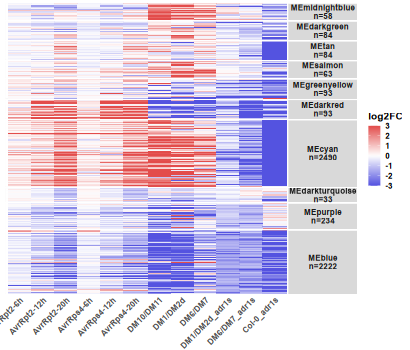

In [102]:
width_ = 8.2
height_ = 7
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 50)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
         strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines") ## spacing between facets
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.png'), width = width_, height = height_ , dpi = 1200)

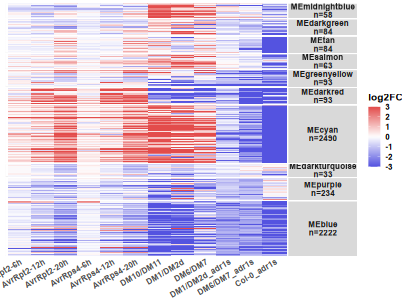

In [103]:
width_ = 8.2
height_ = 6
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 50)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 30, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
         strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines") ## spacing between facets
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.png'), width = width_, height = height_ , dpi = 1200)

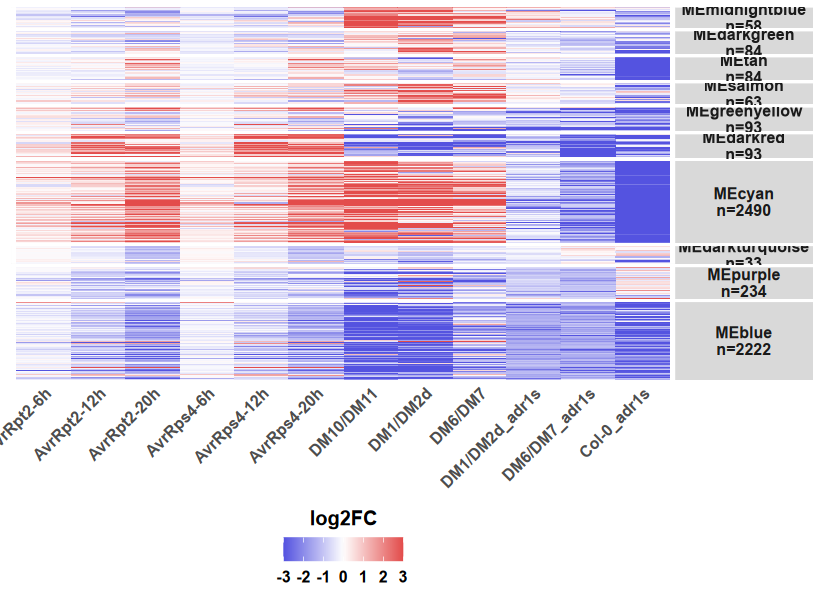

In [104]:
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 100)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.2, "lines"), ## spacing between facets
        legend.position = "bottom"
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 6)

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )


### used for publication Figure 3

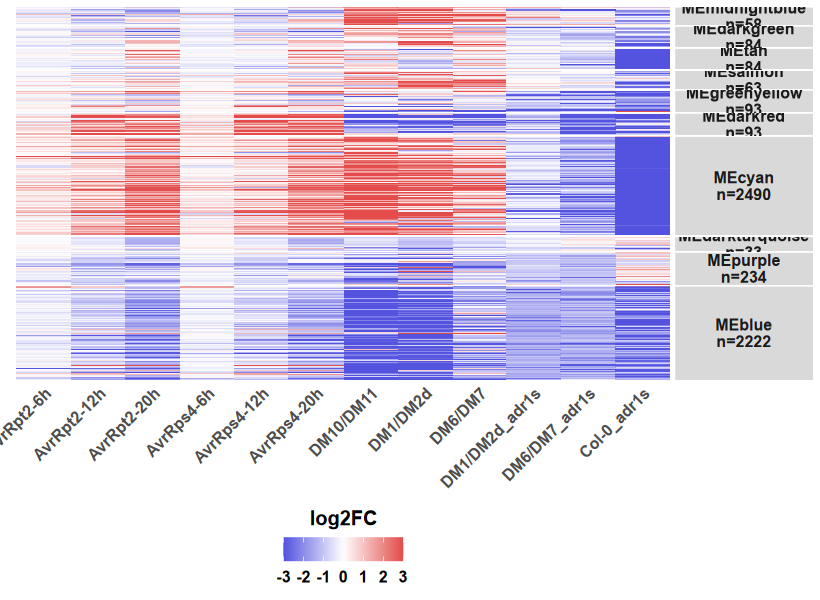

In [105]:
options(repr.plot.width= width_ , repr.plot.height= height_ , repr.plot.res = 100)

library(RColorBrewer)
plot <- Res_combined %>% ggplot(aes(x = source, y = AGI, fill = log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c( '#e34c4b', 'white', '#5453e0' )))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish # out of limit values use max or min color
    )  +
    facet_grid(Module_n ~ ., scales = "free_y", space = "free_y") + 
    theme(
        text = element_text(face="bold", size=14,  family = 'Helvetica'),
        axis.text.y = element_blank(),
        axis.line  = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),  # Make facet labels horizontal
        panel.spacing = unit(0.13, "lines"), ## spacing between facets
        legend.position = "bottom"
    ) 

module_list_sqrt <- lapply(module_list, sqrt) #some modules too few genes
module_list_sqrt_plus <- lapply(module_list_sqrt, function(x) x + 1 )

plot1 <- plot + force_panelsizes(rows = module_list_sqrt_plus)
plot1
# plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), height = 8, width = 8.3)
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.pdf'), width = width_, height = height_ )
plot1 %>% ggsave(file = paste0(plots_path, 'heatmap', Sys.time(), '.png'), width = width_, height = height_ )

In [106]:
plots_path

[1] "./WGCNA_output_all/plots/"

In [107]:
module_list

$MEmidnightblue
[1] 58

$MEdarkgreen
[1] 84

$MEtan
[1] 84

$MEsalmon
[1] 63

$MEgreenyellow
[1] 93

$MEdarkred
[1] 93

$MEcyan
[1] 2490

$MEdarkturquoise
[1] 33

$MEpurple
[1] 234

$MEblue
[1] 2222

In [108]:
module_list %>% as.matrix

[,1]
MEmidnightblue    58
MEdarkgreen       84
MEtan             84
MEsalmon          63
MEgreenyellow     93
MEdarkred         93
MEcyan          2490
MEdarkturquoise   33
MEpurple         234
MEblue          2222

In [109]:
Res_combined %>% pull(source) %>% unique

[1] DM6/DM7        DM1/DM2d       DM10/DM11      AvrRpt2-6h     AvrRpt2-12h   
 [6] AvrRpt2-20h    AvrRps4-6h     AvrRps4-12h    AvrRps4-20h    DM1/DM2d_adr1s
[11] Col-0_adr1s    DM6/DM7_adr1s 
12 Levels: AvrRpt2-6h AvrRpt2-12h AvrRpt2-20h AvrRps4-6h ... Col-0_adr1s

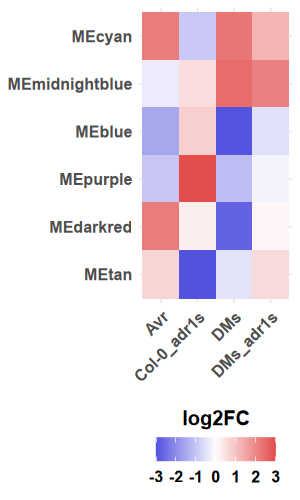

In [110]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(forcats)

# Update plot settings
width_ <- 3
height_ <- 5
options(repr.plot.width= width_, repr.plot.height= height_, repr.plot.res = 100)

# Data processing and ggplot
plot_tile <- Res_combined %>%
  mutate(module = factor(module, levels = c('MEcyan', 'MEmidnightblue', 'MEblue', 'MEpurple', 'MEdarkred', 'MEtan'))) %>%
    filter(str_detect(source, 'AvrRpt2-20h|DM1/DM2d|DM1/DM2d_adr1s|Col-0_adr1s')) %>%
    group_by(source, module) %>%
    summarize(mean_log2FC = mean(log2FC), .groups = 'drop') %>%
    ungroup() %>% filter(module %>% str_detect('MEcyan|MEmidnightblue|MEblue|MEdarkred|MEpurple|MEdarkred|MEtan')) %>%
    mutate( source = source %>% str_replace_all('AvrRpt2-20h', 'Avr') %>% str_replace_all('DM1/DM2d', 'DMs') ) %>%
    mutate(module = fct_rev(module)) %>%  # Reverses the order of module factor levels
    ggplot(aes(x = source, y = module, fill = mean_log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c('#e34c4b', 'white', '#5453e0')))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish
    ) + theme_minimal()+
    theme(
        text = element_text(face="bold", size=14, family = 'Helvetica'),
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),
        panel.spacing = unit(0.2, "lines"),
        legend.position = "bottom"
    )
plot_tile
plot_tile %>% ggsave(file = paste0(plots_path, 'tile', Sys.time(), '.pdf'), width = width_, height = height_ )

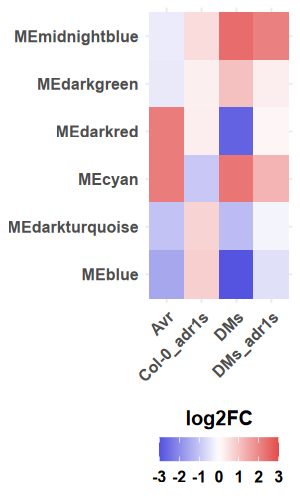

In [111]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(forcats)

# Update plot settings
width_ <- 3
height_ <- 5
options(repr.plot.width= width_, repr.plot.height= height_, repr.plot.res = 100)

# Data processing and ggplot
plot_tile <- Res_combined %>% 
    filter(str_detect(source, 'AvrRpt2-20h|DM1/DM2d|DM1/DM2d_adr1s|Col-0_adr1s')) %>%
    group_by(source, module) %>%
    summarize(mean_log2FC = mean(log2FC), .groups = 'drop') %>%
    ungroup() %>% filter(module %>% str_detect('MEcyan|MEmidnightblue|MEblue|MEdarkred|MEPurple|MEdark')) %>%
    mutate( source = source %>% str_replace_all('AvrRpt2-20h', 'Avr') %>% str_replace_all('DM1/DM2d', 'DMs') ) %>%
    mutate(module = fct_rev(module)) %>%  # Reverses the order of module factor levels
    ggplot(aes(x = source, y = module, fill = mean_log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c('#e34c4b', 'white', '#5453e0')))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish
    ) + theme_minimal()+
    theme(
        text = element_text(face="bold", size=14, family = 'Helvetica'),
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),
        panel.spacing = unit(0.2, "lines"),
        legend.position = "bottom"
    )
plot_tile
plot_tile %>% ggsave(file = paste0(plots_path, 'tile', Sys.time(), '.pdf'), width = width_, height = height_ )

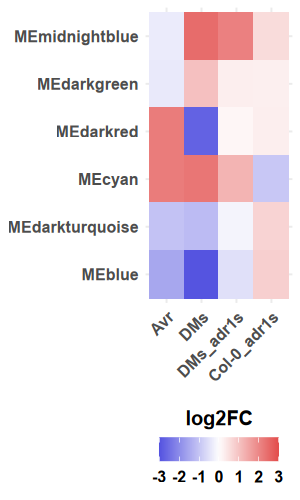

In [112]:
library(RColorBrewer)
library(ggplot2)
library(dplyr)
library(forcats)

# Update plot settings
width_ <- 3
height_ <- 5
options(repr.plot.width= width_, repr.plot.height= height_, repr.plot.res = 100)

# Data processing and ggplot
plot_tile <- Res_combined %>% 
    filter(str_detect(source, 'AvrRpt2-20h|DM1/DM2d|DM1/DM2d_adr1s|Col-0_adr1s')) %>%
    group_by(source, module) %>%
    summarize(mean_log2FC = mean(log2FC), .groups = 'drop') %>%
    ungroup() %>%
    filter(str_detect(module, 'MEcyan|MEmidnightblue|MEblue|MEdarkred|MEPurple|MEdark')) %>%
    mutate(source = str_replace_all(source, 'AvrRpt2-20h', 'Avr')) %>%
    mutate(source = str_replace_all(source, 'DM1/DM2d', 'DMs')) %>%
    mutate(module = fct_rev(module)) %>%  # Reverses the order of module factor levels
    mutate(source = fct_relevel(source, 'Avr', 'DMs', 'DMs_adr1s', 'Col-0_adr1s')) %>% # Reorder x-axis
    ggplot(aes(x = source, y = module, fill = mean_log2FC)) +
    geom_tile() +
    scale_fill_gradientn(
        colors = colorRampPalette(rev(c('#e34c4b', 'white', '#5453e0')))(30),
        limits = c(-3, 3),
        guide = guide_colorbar(title = "log2FC", title.position = "top", title.hjust = 0.5, direction = "horizontal"),
        oob = scales::oob_squish
    ) + 
    theme_minimal() +
    theme(
        text = element_text(face="bold", size=14, family = 'Helvetica'),
        axis.line = element_blank(),
        axis.text.x = element_text(angle = 45, hjust = 1),
        axis.title = element_blank(),
        axis.ticks = element_blank(),
        strip.text.y = element_text(angle = 0),
        panel.spacing = unit(0.2, "lines"),
        legend.position = "bottom"
    )

plot_tile

plot_tile %>% ggsave(file = paste0(plots_path, 'tile', Sys.time(), '.pdf'), width = width_, height = height_ )

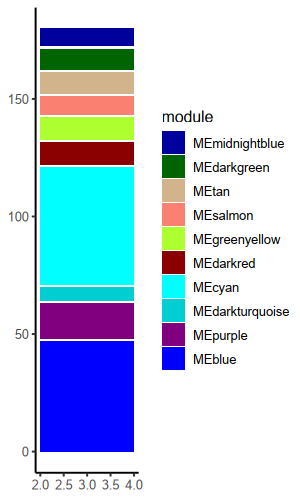

In [113]:
library(ggplot2)
library(dplyr)

# Create a data frame
df <- data.frame(
  module = names(module_list_sqrt_plus),
  height = unlist(module_list_sqrt_plus),
  color = unlist(module_colors)
)

# Reorder factor levels
levels_order <- c('MEmidnightblue', 'MEdarkgreen', 'MEtan', 'MEsalmon', 'MEgreenyellow', 'MEdarkred', 'MEcyan', 'MEdarkturquoise', 'MEpurple', 'MEblue')
df$module <- factor(df$module, levels = levels_order)

# Compute y positions with a gap of 0.2 between each tile
df <- df %>%
  arrange(desc(module)) %>%
  mutate(ymin = cumsum(height) - height,
         ymax = cumsum(height) - 1.4)  # subtract 0.2 from ymax to create a space

# Create the plot
tiles <- ggplot(df, aes(fill = module, ymin = ymin, ymax = ymax)) +
  geom_rect(aes(xmin = 2, xmax = 4)) +
  scale_fill_manual(values = module_colors) +
  theme_classic() 

tiles
tiles %>% ggsave(file = paste0(plots_path, 'tiles', Sys.time(), '.pdf'), width = width_, height = height_ )


In [114]:
df %>% select(module, color)

module          color  
MEblue          MEblue          #0000FF
MEpurple        MEpurple        #800080
MEdarkturquoise MEdarkturquoise #00CED1
MEcyan          MEcyan          #00FFFF
MEdarkred       MEdarkred       #8B0000
MEgreenyellow   MEgreenyellow   #ADFF2F
MEsalmon        MEsalmon        #FA8072
MEtan           MEtan           #D2B48C
MEdarkgreen     MEdarkgreen     #006400
MEmidnightblue  MEmidnightblue  #00009C

# biomart

In [115]:
node_data_info <- node_data %>% mutate(module = paste0('ME', module )) %>% mutate(module = factor(module, levels = rownames(moduleTraitCor))) %>% left_join(map_id_name , by =c('gene' = 'gene_id'))

In [116]:
connectivity_table_info <- connectivity_table %>% arrange(desc(connectivity_rowSums_adj)) %>% 
    mutate(module = paste0('ME', module ))  %>% select(-gene_name) %>%
    left_join(map_id_name , by =c('gene' = 'gene_id'))

In [117]:
connectivity_table_info <- connectivity_table_info %>% left_join (
    Res_combined  %>% distinct() %>% pivot_wider(names_from = source, values_from = log2FC) %>% dplyr::select(-module,  -n, -Module_n),
    by = c('gene' = 'AGI'))

In [118]:
require(openxlsx)

wb <- createWorkbook()
for (i in connectivity_table_info %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, connectivity_table_info %>% filter(module == i))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "/connectivity_info.xlsx"), overwrite = T)

In [119]:
connectivity_table_info %>% saveRDS(paste0(WGCNA_export_path, "/RDS/connectivity_info.rds"))

In [120]:
connectivity_table_info

gene      connectivity_rowSums_adj module          gene_name DM6/DM7     
1    AT5G42010 1955.105                 MEcyan          AT5G42010 2.4905480   
2    AT1G63720 1954.528                 MEcyan          AT1G63720 1.9357788   
3    AT3G54150 1952.888                 MEcyan          EFD       3.8155657   
4    AT5G48657 1947.970                 MEcyan          NOI10     3.5014737   
5    AT4G23700 1947.948                 MEcyan          CHX17     6.2025195   
6    AT1G16420 1947.471                 MEcyan          MC8       2.2349881   
7    AT4G19370 1945.758                 MEcyan          MWL-2     1.9014598   
8    AT2G30750 1945.046                 MEcyan          CYP71A12  2.5859613   
9    AT1G08940 1944.577                 MEcyan          AT1G08940 2.7835286   
10   AT3G45040 1942.043                 MEcyan          DOK1      1.1311398   
11   AT3G13910 1941.590                 MEcyan          AT3G13910 1.6641550   
12   AT5G25930 1941.522                 MEcyan          HSL3      2.4517477   
13   AT3G54620 1941.121                 MEcyan          BZIP25    1.1117048   
14   AT1G62300 1940.692                 MEcyan          WRKY6     2.2015418   
15   AT5G54840 1940.626                 MEcyan          SGP1      1.1472414   
16   AT1G48490 1940.432                 MEcyan          IRE3      0.8158062   
17   AT1G14870 1939.842                 MEcyan          PCR2      3.4751251   
18   AT4G39670 1938.679                 MEcyan          GLTP      2.7178312   
19   AT2G23450 1938.503                 MEcyan          AT2G23450 1.1460680   
20   AT3G05360 1938.475                 MEcyan          RLP30     2.1669162   
21   AT3G13950 1938.373                 MEcyan          AT3G13950 4.0624212   
22   AT4G25900 1937.716                 MEcyan          AT4G25900 2.5795745   
23   AT4G15610 1937.626                 MEcyan          CASPL1D1  4.6937303   
24   AT1G23440 1936.934                 MEcyan          AT1G23440 0.9034568   
25   AT4G02740 1936.673                 MEcyan          AT4G02740 0.5051533   
26   AT1G10410 1935.880                 MEcyan          AT1G10410 1.9132669   
27   AT1G76150 1934.595                 MEcyan          ECH2      1.4743308   
28   AT3G49780 1933.758                 MEcyan          PSK4      1.2326743   
29   AT3G19660 1933.744                 MEcyan          AT3G19660 2.5784469   
30   AT2G15390 1932.937                 MEcyan          FUT4      3.5198490   
⋮    ⋮         ⋮                        ⋮               ⋮         ⋮           
5425 AT2G37690 26.73018                 MEdarkturquoise AT2G37690 -0.650732941
5426 AT4G15640 26.50724                 MEdarkturquoise MS83      -0.527028971
5427 AT4G26600 26.17906                 MEdarkturquoise NOP2B     -0.429906648
5428 AT1G63660 26.14968                 MEdarkturquoise AT1G63660 -0.711412380
5429 AT5G09840 26.12591                 MEdarkturquoise MNU2      -0.317394962
5430 AT1G24090 26.11746                 MEdarkturquoise RNH1C      0.267468718
5431 AT5G66960 26.05457                 MEdarkturquoise AT5G66960 -1.402948187
5432 AT5G27120 26.02092                 MEdarkturquoise AT5G27120 -0.561532111
5433 AT3G07050 25.80763                 MEdarkturquoise NSN1      -0.144069778
5434 AT4G00620 25.79230                 MEdarkturquoise EMB3127   -0.773260290
5435 AT1G80270 25.75008                 MEdarkturquoise PPR596    -0.762613236
5436 AT3G44750 25.60299                 MEdarkturquoise HDA3      -0.927013734
5437 AT2G42910 25.23794                 MEdarkturquoise PRS4      -0.329564203
5438 AT3G06320 24.39139                 MEdarkturquoise AT3G06320 -0.703027510
5439 AT2G20490 24.25209                 MEdarkturquoise NOP10     -0.841066223
5440 AT2G05632 24.16622                 MEdarkturquoise AT2G05632 -2.864080962
5441 AT3G15590 24.15335                 MEdarkturquoise DWEORG1    0.172368743
5442 AT1G15480 23.96583                 MEdarkturquoise POCO1     -0.574241293
5443 AT3G19170 23.83410                 MEdarkturquoise

In [121]:
#get current working dir, 
getwd()


[1] "/media/HDD2/donghui/Pathogen_JC14_3DM"

In [122]:
connectivity_table_info %>% write.csv( paste0(WGCNA_export_path, "/connectivity_info.csv"), 
                                      row.names= F)

In [123]:
connectivity_table_info %>% filter(gene == 'AT4G14400')

gene      connectivity_rowSums_adj module         gene_name DM6/DM7  
1 AT4G14400 43.67565                 MEmidnightblue ACD6      0.8719869
  DM1/DM2d DM10/DM11 AvrRpt2-6h AvrRpt2-12h AvrRpt2-20h AvrRps4-6h AvrRps4-12h
1 1.170846 3.203292  -0.9185255 -1.435681   -1.928172   -0.9543068 -2.032126  
  AvrRps4-20h DM1/DM2d_adr1s Col-0_adr1s DM6/DM7_adr1s
1 -0.9351258  4.762549       -0.7178424  1.339111

In [124]:
connectivity_table_info %>% filter(gene == 'AT4G14390')

gene connectivity_rowSums_adj module gene_name DM6/DM7 DM1/DM2d DM10/DM11
     AvrRpt2-6h AvrRpt2-12h AvrRpt2-20h AvrRps4-6h AvrRps4-12h AvrRps4-20h
     DM1/DM2d_adr1s Col-0_adr1s DM6/DM7_adr1s

In [125]:
library(biomaRt)
# library(Biostrings)
# library(BSgenome.Athaliana.TAIR.TAIR9)

In [126]:
# Specify the genes of interest
genes_of_interest <- top_50_each_module$gene

# Use the BioMart database
plant_mart <- useMart(biomart = "plants_mart", host="https://plants.ensembl.org")
athaliana <- useDataset("athaliana_eg_gene", mart = plant_mart)

# Get the gene information
gene_info <- getBM(attributes=c('ensembl_gene_id', 'chromosome_name', 'strand', 'start_position', 'end_position', 'transcription_start_site'),
                   filters = 'ensembl_gene_id',
                   values = genes_of_interest,
                   mart = athaliana)

# Separate dataframe by strand
strand_positive <- gene_info %>% filter(strand == 1)
strand_negative <- gene_info %>% filter(strand == -1)

# For strand == 1, keep row with min transcription_start_site
strand_positive <- strand_positive %>% 
  group_by(ensembl_gene_id) %>% 
  filter(transcription_start_site == min(transcription_start_site))

# For strand == -1, keep row with max transcription_start_site
strand_negative <- strand_negative %>% 
  group_by(ensembl_gene_id) %>% 
  filter(transcription_start_site == max(transcription_start_site))

# Combine the dataframes
gene_info_filtered <- bind_rows(strand_positive, strand_negative) %>%
    filter(ensembl_gene_id %>% str_detect('AT\\dG'))

In [127]:
# Initialize an empty list to store the sequences
sequences <- list()

# Loop over the filtered gene info dataframe
for (i in 1:nrow(gene_info_filtered)) {
  # Get the current gene's info
  current_gene <- gene_info_filtered[i, ]
  
  # Calculate the start and end positions
  if (current_gene$strand == 1) {
    start <- current_gene$transcription_start_site - 1799
    end <- current_gene$transcription_start_site + 200
  } else {
    start <- current_gene$transcription_start_site - 200
    end <- current_gene$transcription_start_site + 1799
  }
  
  # Extract the sequence
  sequence <- getSeq(BSgenome.Athaliana.TAIR.TAIR9, 
                     names = paste0("Chr", current_gene$chromosome_name),
                     start = start,
                     end = end)
  
  # If the gene is on the negative strand, reverse complement the sequence
  if (current_gene$strand == -1) {
    sequence <- reverseComplement(sequence)
  }
  
  # Add the sequence to the list, with the gene ID as the name
  sequences[[current_gene$ensembl_gene_id]] <- sequence
}

# Convert the list to a DNAStringSet
sequences_set <- DNAStringSet(unlist(sequences))

# Add names to the DNAStringSet
names(sequences_set) <- names(sequences)

# Write the sequences to a FASTA file
writeXStringSet(sequences_set, filepath = paste0(WGCNA_export_path, '/', "promtoters.fasta"))



ERROR: Error in getSeq(BSgenome.Athaliana.TAIR.TAIR9, names = paste0("Chr", current_gene$chromosome_name), : could not find function "getSeq"


In [ ]:
plantregmap_top50_each_module <- read.csv('./plantregmap/plantTFBS_fimo.txt', sep = '\t') %>% 
    dplyr::select(1, 3) %>% dplyr::rename('TF' = 'X.pattern.name', 'target' = 'sequence.name' ) 

In [ ]:
plantregmap_top50_each_module <- plantregmap_top50_each_module %>% semi_join(top_50_each_module, by = c('TF' = 'gene')) %>%
    semi_join(top_50_each_module, by = c('target' = 'gene')) %>% group_by(TF, target) %>% 
    summarise(TF_weight = n()) %>% mutate(source = 'TF') 

  #  write.csv(paste0(WGCNA_export_path, 'TF_top50_each_module', ".csv"), row.names = F, quote = F)

In [ ]:
plantregmap_top50_each_module %>% dplyr::rename('fromNode' = 'TF', 'toNode' = 'target') %>% 
    mutate(direction = 'directed', weight = NA)  %>% rbind(
    top_50_each_module_edge %>% mutate(source = 'correlation', TF_weight = NA) %>%
    dplyr::select(-toAltName, - fromAltName)
    ) %>% write.csv(paste0(WGCNA_export_path,'/', 'TF+WGCNA_top50_each_module', ".csv"), row.names = F, quote = F)

## NLRs LRRs in WGCNA modules

In [ ]:
NLRs_and_TIRs <- read.csv(file = "../gene_table_and_other_scripts/NLRs_and_TIR_only.csv") %>%
    dplyr::rename('GeneFamily' = 'Class')

In [ ]:
NLRs_and_TIRs_connectivity_table_info <- connectivity_table_info %>% semi_join(NLRs_and_TIRs, by = c('gene'= 'AGI')) %>%
    left_join(NLRs_and_TIRs, by = c('gene'= 'AGI'))

In [ ]:
connectivity_table_info

In [ ]:
require(openxlsx)

NLRs_and_TIRs_connectivity_table_info %>% write.csv(paste0(WGCNA_export_path, '/','NLRs_and_TIRs_connectivity_table_info', ".csv"), row.names = F, quote = F)

wb <- createWorkbook()
for (i in NLRs_and_TIRs_connectivity_table_info %>% pull(module) %>% unique) {
#     print(i)
    addWorksheet(wb, i)
    writeData(wb, i, NLRs_and_TIRs_connectivity_table_info %>% filter(module == i) %>% arrange(GeneFamily))
    
}
saveWorkbook(wb, file = paste0(WGCNA_export_path, "/NLRs_and_TIRs_connectivity_table_info.xlsx"), overwrite = T)

In [ ]:
NLRs_and_TIRs_connectivity_table_info %>% filter(GeneFamily != 'TIR') 

In [ ]:
Pathways_Ngou_2021 <- readxl::read_excel("../gene_table_and_other_scripts/Ngou_2021_Nature_figure2E_pathways_mod.xlsx")

In [ ]:
Pathways <- Pathways_Ngou_2021 %>% dplyr::select(Target, GeneFamily)
Pathways <- Pathways %>%as.data.frame  %>% dplyr::rename('AGI' = 'Target')
LRRs <- Pathways %>% filter(GeneFamily %>% str_detect('LRR'))

In [ ]:
connectivity_table_info %>% semi_join(LRRs, by = c('gene'= 'AGI')) %>%
    left_join(LRRs, by = c('gene'= 'AGI'))  %>% write.csv(paste0(WGCNA_export_path, '/','LRRs_connectivity_table_info', ".csv"), row.names = F, quote = F)

In [ ]:
connectivity_table_info %>% write.csv(paste0(WGCNA_export_path, '/','connectivity_table_info', ".csv"), row.names = F, quote = F)

In [ ]:
connectivity_table_info %>% sample_n(10)

[1] "MEruby"          "MEblue"          "MEpaleblue"      "MEdarkred"      
 [5] "MEgreenyellow"   "MEtan"           "MEdarkgreen"     "MEsalmon"       
 [9] "MEorange"        "MEdarkturquoise"

### write out to one excel sheet

In [136]:
connectivity_table_info2 <- connectivity_table_info %>%
  mutate(module = case_when(
    module == "MEcyan" ~ "MEruby",
    module == "MEpurple" ~ "MEpaleblue", 
    module == "MEmidnightblue" ~ "MEorange",
    TRUE ~ module  # keeps all other values unchanged
  ))

connectivity_table_info2 %>% pull(module) %>% unique


library(openxlsx)

# Create workbook
wb <- createWorkbook()
addWorksheet(wb, "connectivity_data")

# Write the data
writeData(wb, "connectivity_data", connectivity_table_info2)

# Define color mapping based on your image
module_colors <- c(
  "MEorange" = "#FFA500",         # Orange
  "MEdarkgreen" = "#006400",      # Dark green
  "MEtan" = "#D2B48C",            # Tan/beige
  "MEsalmon" = "#FA8072",         # Salmon/pink
  "MEgreenyellow" = "#ADFF2F",    # Green yellow/lime
  "MEdarkred" = "#8B0000",        # Dark red/maroon
  "MEruby" = "#DC143C",           # Ruby/crimson red
  "MEdarkturquoise" = "#40E0D0",  # Dark turquoise/cyan
  "MEpaleblue" = "#87CEEB",       # Pale blue/light blue
  "MEblue" = "#0000FF"            # Blue
)

# Find the module column index
module_col <- which(names(connectivity_table_info2) == "module")

# Group rows by module and apply styles in batches
for(module_name in names(module_colors)) {
  # Get all rows for this module
  rows_for_module <- which(connectivity_table_info2$module == module_name) + 1  # +1 for header
  
  if(length(rows_for_module) > 0) {
    # Create style once
    style <- createStyle(fgFill = module_colors[module_name])
    # Apply to all rows at once
    addStyle(wb, "connectivity_data", style, rows = rows_for_module, cols = module_col)
  }
}

# Save the workbook
saveWorkbook(wb, "connectivity_table_colored.xlsx", overwrite = TRUE)

[1] "MEruby"          "MEblue"          "MEpaleblue"      "MEdarkred"      
 [5] "MEgreenyellow"   "MEtan"           "MEdarkgreen"     "MEsalmon"       
 [9] "MEorange"        "MEdarkturquoise"